## Contexte

L'objectif est de compter les fruits présents à l'intérieur du cadre blanc sur les images tout en estimant leur poids. Pour cela, deux modèles sont combinés à savoir YOLOv8 pour segmenter les fruits et U-NET pour segmenter le cadre. L'estimation du poids des fruits se base sur le poids moyen de la catégorie de fruits qui est fourni par la moyenne du rapport largeur/longueur des fruits.



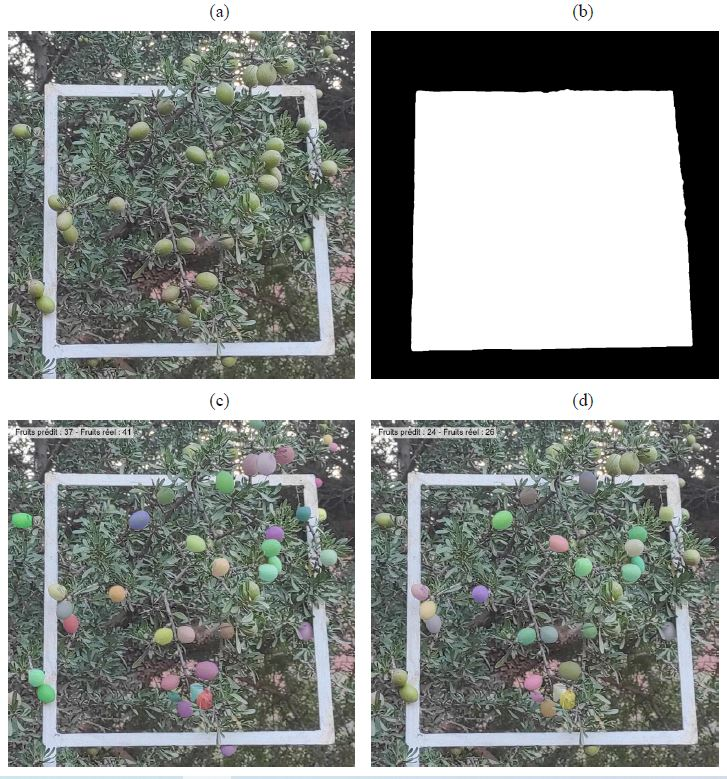

## Installer les modules requis

In [1]:
!pip install ultralytics
!pip install patched_yolo_infer
# !pip install sahi
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.4/799.4 kB 5.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

## Importer les modules

In [2]:
from PIL import Image, ImageDraw, ImageFont
import os, glob, tqdm
import numpy as np
from ultralytics import YOLO
import cv2
from patched_yolo_infer import MakeCropsDetectThem, CombineDetections
from patched_yolo_infer import visualize_results
import random

import cv2
from patched_yolo_infer import MakeCropsDetectThem, CombineDetections
from patched_yolo_infer import visualize_results

from pathlib import Path
import albumentations as A

import numpy
import numpy as np
from PIL import Image, ImageDraw
import os
import glob
from tqdm import tqdm
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss
from torch.utils.data import Dataset, DataLoader
# from torcheval.metrics.functional import multiclass_f1_score, multiclass_accuracy, multiclass_precision, multiclass_recall

import cv2
import albumentations as A
from albumentations import Compose, Resize
from albumentations.pytorch.transforms import ToTensorV2

from skimage.measure import label, regionprops, find_contours
import skimage
from skimage.util.shape import view_as_blocks
from skimage import io
from skimage.transform import resize
from scipy import ndimage

from pathlib import Path
import yaml


from PIL import Image, ImageDraw
import os, glob, tqdm
import numpy as np
from ultralytics import YOLO
import cv2
from patched_yolo_infer import MakeCropsDetectThem, CombineDetections
from patched_yolo_infer import visualize_results


from skimage.measure import find_contours
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
from skimage import io
import math


from skimage import measure
import skimage
from skimage.morphology import remove_small_holes
from skimage import morphology
from skimage.morphology import diameter_closing
from scipy import ndimage


from sklearn.model_selection import train_test_split

import logging
logging.disable(logging.WARNING)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Outils du modèle de segmentation du cadre

In [3]:

from typing import Callable, Union, List, Optional, Tuple


def find_good_length(initial_length: int, total_length: int):
    """
    Find the good length such that the total_length % good_length == 0

    args :
        initial_length : longueur initial
        total_length : la longueur total

    return :
        good_length : la longueur la plus proche de initial_length de telle sorte que
        total_length % good_length == 0
    """
    good_lower_length = 0
    good_higher_length = 0

    for width1 in range(initial_length, 0, -1):
        if total_length % width1 == 0:
            good_lower_length = width1
            break

    for width2 in range(initial_length, total_length + 1, 1):
        if total_length % width2 == 0:
            good_higher_length = width2
            break

    good_length = good_lower_length
    if abs(initial_length - good_higher_length) <= abs(initial_length - good_lower_length):
        good_length = good_higher_length

    return good_length

def find_closest_dividor(initial_number: int, divisor: int):
    """
    Find a number that can be divided by the dividor such that the this number is the closest to initial_number

    args :
        initial_number : le nombre initial à diviser par le diviseur
        divisor : le diviseur

    return :
        good_length : la longueur la plus proche de initial_length de telle sorte que
        total_length % good_length == 0
    """
    good_lower_length = 0
    good_higher_length = 0

    for width1 in range(initial_number, 0, -1):
        if width1 % divisor == 0:
            good_lower_length = width1
            break

    for width2 in range(initial_number, initial_number + divisor + 1, 1):
        if width2 % divisor == 0:
            good_higher_length = width2
            break

    good_length = good_lower_length
    if abs(initial_number - good_higher_length) <= abs(initial_number - good_lower_length):
        good_length = good_higher_length

    return good_length

# ================== Custom exceptions : put it in a exceptions.py or errors.py ===============================
class InvalidFileError(Exception):
  """
  This exception is raised if the given file is not among the recognized files extensions like .jpg, .yml, etc

  message: explanation message
  """
  def __init__(self, message):
    self.message = message

    super().__init__(self.message)


class InvalidShapeError(Exception):
  """
  This exception is raised if the given image doesn't match the expected shape

  message: explanation message
  """
  def __init__(self, message):
    self.message = message

    super().__init__(self.message)


class InvalidTypeError(Exception):
  """
  This exception is raised if the type received is not what is expected

  message: explanation message
  """
  def __init__(self, message):
    self.message = message

    super().__init__(self.message)


# ================= Utils files ==========
ALLOWED_IMAGES_EXTENSIONS = [".jpg", ".jpeg"]
def check_yaml(model_architecture="unet", config_file=None):
  """
  Check if the config file is valid for the given architecture.
  We must open the file using the yaml library then check the configuration
  it must contain some attributes.
  """

  def _check_unet_cfg(config_file):
    """Checking for unet"""
    return True

  if model_architecture == "unet":
    return _check_unet_cfg(config_file)


def get_unet_config(path):
  """

  """
  if check_yaml(model_architecture="unet", config_file=path):
    with open(path, "r") as f:
      config = yaml.safe_load(f)
      model_name = config['architecture_config']['model_name']
      encoder = config['architecture_config']['encoder_name']
      encoder_depth = config['architecture_config']['encoder_depth']
      encoder_weights = config['architecture_config']['encoder_weights']
      decoder_use_batchnorm = config['architecture_config']['decoder_use_batchnorm']
      decoder_attention_type = config['architecture_config']['decoder_attention_type']
      decoder_channels = config['architecture_config']['decoder_channels']
      in_channels = config['architecture_config']['in_channels']
      n_classes = config['architecture_config']['classes']
      activation = config['architecture_config']['activation']
      cpkt_path = config['architecture_config']['checkpoint_path']

      return {
          "model_name": model_name,
          "encoder_name": encoder,
          "encoder_depth": encoder_depth,
          "decoder_use_batchnorm": decoder_use_batchnorm,
          "decoder_channels": tuple(decoder_channels),
          "decoder_attention_type": decoder_attention_type,
          "in_channels": in_channels,
          "classes": n_classes,
          "activation": activation,
          "cpkt_path": cpkt_path
      }


def build_model_from_dict_config(config=None, architecture="unet"):
  """Build a unet model from the configuration
  args:
    config: a dictionary containing the keywords along with their values to build
    the model from
    architecture: one of the base architecture available in segmentation-models-pytorch
      "unet", "fpn", "pspnet", etc.
  """
  if architecture == "unet":
    return smp.Unet(**config)
  else:
    raise NotImplementedError("Can only build a model for unet. please implement for others")

def get_device():

    DEVICE = 'cpu'
    #
    if torch.cuda.is_available():
        DEVICE = "cuda"

    return DEVICE


def correct_config_dict_for_model(arch="unet", config_dict=None):
  if arch == "unet":
    correct_attributes_unet = ["encoder_name", "encoder_depth", "encoder_weights", \
                              "decoder_use_batchnorm", "decoder_channels", \
                              "decoder_attention_type", "in_channels", "classes", "activation"]
    correct_config = {key: config_dict[key] for key in config_dict if key in correct_attributes_unet}

    correct_config_ = {}
    for key in correct_config:
      if key in ("activation", "decoder_attention_type") and correct_config[key] in ("None", "none"):
        correct_config_[key] = None
      else:
        correct_config_[key] = correct_config[key]

    return correct_config_


def preprocess_input_for_prediction(image: Union[str, np.ndarray, torch.Tensor],
                                    add_batch_dimension: bool = True,
                                    width: int = 640, height: int = 640,
                                    channel_first: bool = False,
                                    normalize: bool = True,
                                    transforms_callback: Callable[..., torch.Tensor] = None) -> torch.Tensor:
    """
    preprocesses an input image to make it ready for prediction

    parameters :
        image : a path to the file or a np.ndarray or a torch.Tensor
        add_batch_dimension :
        width : the output x_size
        height : the output y_size
        channel_first : if the input image is an image or a numpy ndarray, it specifies whether the channel dimension
            is first (channels, rows, cols) or last (rows, cols, channels). Default to False means (rows, cols, channels)
        normalize: whether to normalize the input image or not. Will be normalize by 255. Default to True
        transforms_callback: a  callable that can accept a numpy array and return a torch.Tensor
            with parameters <image_array, x_size, y_size, add_batch_dimension> in this order

    return torch.Tensor

    """
    if isinstance(image, str):
        if Path(image).exists():
            if Path(image).suffix in ALLOWED_IMAGES_EXTENSIONS:
                path = str(Path(image)).replace("\\", "/")
                image_array = io.imread(path, as_gray=False)
            else:
                raise InvalidFileError(f"{image} is not a valid format. \
                                             Accepted formats are {ALLOWED_IMAGES_EXTENSIONS}")
        else:
            raise FileNotFoundError(f"Cannot find the file {image}. Please provide the right path to the image.")
    elif isinstance(image, np.ndarray):
        image_array = image
    else: # It is a tensor
        image_array = image.numpy(force=True)

    # Check the dimensions of the image : number of dimensions then number of channels
    if len(image_array.shape) == 3:
        # Check if the number of channels is 3
        if channel_first:
          if image_array.shape[0] != 3:
            raise InvalidShapeError(f"The image is expected to have 3 channels, found {image_array.shape[0]}")
          else:
            image_array = image_array.transpose((1, 2, 0))
        elif not channel_first:
            if image_array.shape[-1] != 3:
                raise InvalidShapeError(f"The image is expected to have 3 channels, found {image_array.shape[-1]}")
    else:
        raise InvalidShapeError(f"Your image has len(image_array.shape) dimensions. The expected number of dimensions \
                                    is 3")

    if normalize:
        image_array = image_array / 255.0

    # If a callback is provided, it will be returned, else, the image will be resized
    if transforms_callback is not None:
        return transforms_callback(image_array, width, height, add_batch_dimension)
    else:
        image_tensor = Compose([
            Resize(height, width),
            ToTensorV2() # Transfor from HWC to CHW
        ])(image=image_array)["image"]

    # Add a batch dimension to the image_tensor (channels, rows, cols) -> (1, channels, rows, cols)
    if add_batch_dimension:
        image_tensor = torch.unsqueeze(image_tensor, dim=0)

    return image_tensor.type(torch.float)


def check_dict_keys_for_train(dict_, keys):
  """
  Check if the dict contains the keys
  """
  for key in keys:
    if key not in dict_:
      raise KeyError(f"{key} is not in the dict")
    else:
      if not isinstance(dict_[key], str):
        raise TypeError(f"{dict_[key]} must be a path to the data")
      if not Path(dict_[key]).exists():
        raise FileNotFoundError(f"{dict_[key]} is not found! please check your path!")



class SegmentationModel(nn.Module):
  """Class de base pour la segmentation d'images"""
  """
  args:
    model :
      - yaml config file containing the models configuration
      - pretrained_model : .pt file
    type :
      - pretrained
      - config_file
  """
  def __init__(self, model: str = None, model_name="unet"):
    super().__init__()
    self.model_config = model
    self.model_name = model_name
    self.model = None
    self.model_building_config = None
    self.trainer = None

    # Build the model form the configuration
    self._build_model()
    self.to(get_device())

  def __call__(self, x):
    """
    Effectuer une prédiction
    """
    return self.model(x)


  def forward(self, x):
    """
    Effectuer une prédiction
    """
    return self.model(x)

  def fit(self, donnees_dict: dict=None, augmentations: A.Compose = None, batch_size=8, image_size=640, save_dir=None, epochs=100, train_checkpoint=None):
    """Train the model
    donnees_dict : the data to use for training :
      - train_images: images and masks for training
      - train_masks: masks for training
      - val_images: images and masks for validation
      - val_masks: masks for validation
    batch_size : the batch size to use for training
    image_size : the image size to use for training
    save_dir : the directory to save the model
    """
    # vérifier la validité des paramètres
    if not isinstance(epochs, int):
      raise TypeError("epochs must be an integer")
    if not isinstance(donnees_dict, dict):
      raise TypeError("data must be a dictionary")
    else:
      check_dict_keys_for_train(dict_=donnees_dict, keys=["train_images", "train_masks", "val_images", "val_masks"])
    """if augmentations is not None:
      if not isinstance(augmentations, A.Compose):
        raise TypeError("augmentations must be an instance of A.Compose")"""
    if not isinstance(batch_size, int):
      raise TypeError("batch_size must be an integer")
    if not isinstance(image_size, int):
      raise TypeError("image_size must be an integer")

    if save_dir is not None and not isinstance(save_dir, str):
      raise TypeError("save_dir must be a string")

    if not Path(save_dir).parent.exists():
      raise FileNotFoundError(f"{save_dir} not found! Check the directory!")
    else:
      Path(save_dir).mkdir(exist_ok=True)

    if save_dir is None:
      save_dir = str(Path().cwd() / "runs")
      Path(save_dir).mkdir(exist_ok=True)

    # --------------- Get train and val data configs --------------------
    n_classes = self.model_building_config["classes"]
    if n_classes == 1:
      classes_pixels_values = [0, 255]
      classes_names = ["background", "Cadre"]
      labels_mapping = {0: 0, 255: 1}
    elif n_classes == 3:
      classes_pixels_values = [0, 128, 255]
      classes_names = ["background", "fruit", "edge"]
      labels_mapping = {0: 0, 128: 1, 255: 2}
    else:
      raise ValueError("Only 1 or 3 classes are supported!")

    train_data_dict = {"images": donnees_dict["train_images"], "labels_masks": donnees_dict["train_masks"]}
    val_data_dict = {"images": donnees_dict["val_images"], "labels_masks": donnees_dict["val_masks"]}

    train_data_cfg = DatasetConfig(batch_size, image_size, augmentations, n_classes,
                                   classes_pixels_values, classes_names, labels_mapping,
                                   data_config=train_data_dict)
    val_data_cfg = DatasetConfig(batch_size, image_size, None, n_classes,
                                 classes_pixels_values, classes_names, labels_mapping,
                                 data_config=val_data_dict)
    # ----------------- Send the task to to trainer --------------- data, model, epochs, save_dir
    self.trainer = Trainer(model=self, _data={"train": train_data_cfg, "val": val_data_cfg}, epochs=epochs, save_dir=save_dir)
    self.trainer.train(train_checkpoint)

  def predict(self, image: Union[str, np.ndarray] = None, tilling: bool = False, tile_size: int = 360, prediction_size: int = 640, device="cpu"):
    """
    Effectuer une prédiction en utilisant le modèle pré-entrainé.
    image : chemin vers l'image à utilisé ou une image numpy
    tilling : spécifie si on doit faire une prédiction en tuillage. Si True, on doit spécifier n_rows et n_cols
    tile_size: nombre de lignes et colonnes de la tuile. tuile de 2 * 2 découpe l'image en 4 blocks
    prediction_size: taille à laquelle l'image doit être redimensionnée lors pour la prédiction
    """
    if isinstance(image, str):
      if Path(image).exists():
        image_array = io.imread(image)
      else:
        raise FileNotFoundError(f"{image} was not found! please check the good path of your file")
    elif isinstance(image, np.ndarray):
      image_array = image
    else:
      raise TypeError("image must be a string or a numpy array")

    # Check for tile, tile_size, prediction_size and save_path
    if isinstance(tilling, bool):
      if tilling:
        if not isinstance(tile_size, int):
          raise TypeError("tile_size must be an integer")
        if self.model_building_config["classes"] != 3:
          raise ValueError("Only 3 classes are supported for tuiling!")
    else:
      raise TypeError("tilling must be a boolean")

    if not isinstance(prediction_size, int):
          raise TypeError("prediction_size must be an integer")

    # Check the dimensions of the image : HWC with C=3
    if len(image_array.shape) != 3:
      raise InvalidShapeError(f"The image is expected to have 3 channels, found {image_array.shape[-1]}")
    elif image_array.shape[-1] != 3:
      raise InvalidShapeError(f"The image is expected to have 3 channels, found {image_array.shape[-1]}")

    # Put the model on eval mode
    self.eval()
    original_shape = image_array.shape
    prediction_size = find_closest_dividor(initial_number=prediction_size, divisor=32)
    if tilling:
      # Tile the image :
      tiling_results = tile_image(image=image_array, tile_height=tile_size, tile_width=tile_size)
      tiles, n_rows, n_columns, block_shape = tiling_results.values()
      tile_predictions = []
      for r in range(n_rows):
        for c in range(n_columns):
          tile = tiles[r, c].reshape(block_shape)
          # Preprocess the tile for prédiction
          tile_tensor = preprocess_input_for_prediction(image=tile, width=prediction_size, height=prediction_size, normalize=True)
          with torch.no_grad():
            # Predict the mask
            tile_tensor = tile_tensor.to(device)
            tile_mask = self.model(tile_tensor)
            tile_mask = torch.squeeze(tile_mask, dim=0)
            tile_mask = torch.softmax(tile_mask, dim=0)
            tile_mask = torch.argmax(tile_mask, dim=0)
            tile_mask = torch.squeeze(tile_mask, dim=0).cpu().numpy()
            # Resize the tile back to its original size
            tile_mask = resize(tile_mask, (block_shape[0], block_shape[1]), preserve_range=True).astype(np.uint8)
            # Add the prediction to the list of predictions
            tile_predictions.append(tile_mask)
      # Concat tiles predictions
      prediction = concat_tiles(tile_predictions, n_rows, n_columns)
      return prediction
    else:
    # Preprocess the image
      image_tensor = preprocess_input_for_prediction(image=image_array, width=prediction_size, height=prediction_size, normalize=True)
      with torch.no_grad():
        # Predict the mask
        image_tensor = image_tensor.to(device)
        mask = self.model(image_tensor)
      # Delete the batch dimension
      mask = torch.squeeze(mask, dim=0)
      # Apply an activation function
      if self.model_building_config["classes"] == 1:
        mask = torch.sigmoid(mask)
        mask = torch.round(mask)
      else:
        mask = torch.softmax(mask, dim=0)
        mask = torch.argmax(mask, dim=0)

      # Convert the mask to a numpy array
      mask = torch.squeeze(mask, dim=0).cpu().numpy()
      mask = resize(mask, (original_shape[0], original_shape[1]), preserve_range=True).astype(np.uint8)
      # Convert the mask to a numpy array
      return mask

  def _build_model(self):
    """Build the model from a configuration file or from pretrained weights"""
    if Path(self.model_config).exists():
      if Path(self.model_config).suffix in (".yaml", ".yml"):
        return self._build_model_from_yaml()
      elif Path(self.model_config).suffix in (".pt", ".tar"):
        self._build_pretrained_model(device="cpu")
      else:
        raise InvalidFileError(f"{self.model} is not a recognized file.\n Accepted formats are .yml/.yaml/.pt/.tar")
    else:
      raise FileNotFoundError(f"{self.model} was not found! please check the good path of your file")

  def _build_model_from_yaml(self):
    """
    Build the model from yaml configuration file

    if the .yaml/.yml config file is valid, the model will be built
    else:
      raise InvalidConfigFileError("The file self.model_config is not valid")
    """
    if self.model_name == "unet":
      model_config_path = str(Path(self.model_config)).replace("\\", "/")
      if check_yaml(model_architecture="unet", config_file=model_config_path):
        config = get_unet_config(model_config_path)
        self.model_building_config = correct_config_dict_for_model(arch="unet", config_dict=config)
        self.model = build_model_from_dict_config(config=self.model_building_config, architecture="unet")

        # Add a key to specify the models name :
        self.model_building_config["model_name"] = "unet"

        if Path(config["cpkt_path"]).exists():
          self._restore_model_weights(config["cpkt_path"], device=get_device())

  def _restore_model_weights(self, weights, device):
    """Restore a model from weights

     weights : path to the weights file or a dict containing the model weights
    """
    try:
      if isinstance(weights, dict):
        self.load_state_dict(weights)
      else:
        self.load_state_dict(torch.load(weights, map_location=torch.device(device)))
    except:
      raise RuntimeWarning("Failed to load the model weights. Please make sure that the weights file is valid.")

  def _build_pretrained_model(self, device=get_device()):
    """
    Build the model from pretrained weights

    If the model config ends with .pt or .tar, the model will be built

    This file should contain these keys :
      "building_config" : the model configuration. A dict containing the keys
                    "model_name" along with the model architecture keys
      "model_state_dict" : the model weights

    """
    loaded_config = torch.load(self.model_config, map_location=device)
    self.model_building_config = loaded_config["building_config"]
    model_name = self.model_building_config["model_name"]
    arch_config = {
       key:self.model_building_config[key] for key in self.model_building_config
        if key != "model_name"
    }
    if model_name == "unet":
      self.model = build_model_from_dict_config(config=arch_config, architecture="unet")
      model_weights = loaded_config["model_state_dict"]
      # Load the model state
      self._restore_model_weights(model_weights, device)
      # self.load_state_dict(model_weights)
    elif model_name == "fpn":
      self.model = build_model_from_dict_config(config=arch_config, architecture="fpn")
    elif model_name == "unet++":
      self.model = build_model_from_dict_config(config=arch_config, architecture="unet++")

  def __repr__(self):
    return super().__repr__()

  def save(self, path, kwargs=None):
    """Save the model to a file
    This will save informations relative to the model' architecture along with the weights

    Allowed extensions are .pt or .tar

    """
    if kwargs is None:
      kwargs = {}
    if Path(path).suffix in (".pt", ".tar"):
      torch.save({
          "building_config": self.model_building_config,
          "model_state_dict":  self.state_dict(),
          **kwargs
        }, path)


def remove_smallest_blobs(input_mask):
    """
    Remove all the smaller blobs and only keep the biggest one
    """
    labels_mask = measure.label(input_mask)
    regions = measure.regionprops(labels_mask)
    regions.sort(key=lambda x: x.area, reverse=True)
    if len(regions) > 1:
        for rg in regions[1:]:
            labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
    labels_mask[labels_mask!=0] = 1
    return labels_mask

def post_process_mask(input_mask):
  """
    Ops :
      - ne retenir que le plus grand blob
      - remplir tous les trous
  """
  mask = remove_smallest_blobs(input_mask)
  mask_final = ndimage.binary_fill_holes(mask).astype(np.uint8)
  return mask_final



## Outils pour segmenter les fruits

In [4]:
def save_content(liste_data, path):
  """
    Sauvegarder une liste de float au format txt
  """
  content = ",".join([str(e) for e in liste_data])
  with open(path, "w") as f:
    f.writelines(content)


def get_polygons(path_to_label_file: str, image_path: str):
        """
          Permet de récupérer les polygones présents dans un fichier donnée:
          return:
            polygones: [[(x, y), (x, y), (x, y)], ...]
        """
        if os.path.exists(path_to_label_file):
            with open(path_to_label_file) as file:
                content = file.readlines()
                if len(content) > 0:
                    polygones = []
                    W, H = Image.open(image_path).convert("RGB").size
                    for e in content:
                        pol = [float(i) for i in e.split(" ")[1:]]
                        pol = [(pol[j] * W, pol[j + 1] * H) for j in range(0, len(pol), 2)]
                        # pol = [(pol[j], pol[j + 1]) for j in range(0, len(pol), 2)]
                        polygones.append(pol)

                    return polygones

def polygon_to_bbox(polygon):
    x_values = [e[0] for e in polygon]
    y_values = [e[1] for e in polygon]

    x_min, x_max = min(x_values), max(x_values)
    y_min, y_max = min(y_values), max(y_values)

    return x_min, x_max, y_min, y_max

def bbox_to_point(bounding_box):
    """
    bbox:
        x_min, x_max, y_min, y_max

    """
    width = (bounding_box[1] - bounding_box[0]) / 2
    height = (bounding_box[3] - bounding_box[2]) / 2
    column = bounding_box[0] + width
    row = bounding_box[2] + height
    column = int(column)
    row = int(row)
    return column, row

def bboxes_to_points(bounding_boxes):
  """
    bounding_boxes : [[xmin, ymin, xmax, ymax]] bboxes_to_points(pred_boxes)
  """
  points = []
  for bbox__ in bounding_boxes:
    bbox__ = [bbox__[0], bbox__[2], bbox__[1], bbox__[3]]
    x__, y__ = bbox_to_point(bbox__)
    points.append((x__, y__))
  return points


def polygons_to_bboxes(polygons):
    """
    polygons:
        [
            [(x, y), (x, y), ...],
            .....................,
            [(x, y), (x, y), ...]
        ]
    """
    bboxes = []
    for polygon in polygons:
        bbox = polygon_to_bbox(polygon)
        bbox = [bbox[0], bbox[2], bbox[1], bbox[3]]
        bboxes.append(bbox)

    return bboxes


def polygons_to_points(polygons):
    """
    polygons:
        [
            [(x, y), (x, y), ...],
            .....................,
            [(x, y), (x, y), ...]
        ]
    """
    points = []
    for polygon in polygons:
        bbox = polygon_to_bbox(polygon)
        point = bbox_to_point(bbox)
        points.append((point[0], point[1]))

    return points

def get_label_points(path_to_label_file, image_path):
    """
    Convertir les coordonnées des fruits annotées en points
    """
    polygons = get_polygons(path_to_label_file, image_path)
    points = polygons_to_points(polygons)
    return points

def create_points_mask(img_path, polygones_path):
        """
            Créer un mask d'image à partir d'une image et des ses annotations en polygone

            img_path : chemin de l'image
            polygones_path: chemin des polygones de l'image

            background_color: the background color of the image
            fill_color: couleur de remplissage du polygone
            outline_color: couleur de la ligne de contour du polygone
            outline_width: epaisseur de la ligne de contour
        """

        # Récupération des points correspondant à l'image
        points = get_label_points(polygones_path, img_path)

        # Convertire l'image en numpy_array
        imArray = np.asarray(Image.open(img_path))

        # Création du masque:
        # mode=L (8-bit pixels, grayscale)
        maskImage = Image.new(mode='L', size=(imArray.shape[1], imArray.shape[0]), color="black")
        ImageDraw.Draw(maskImage).point(points, fill="white")

        return maskImage


def yolo_pred_to_points(bbox_list):
    """
    bbox : xyxy
    """

    points = []
    for r in bbox_list:
        bbox = (r[0], r[2], r[1], r[3])
        point = bbox_to_point(bbox)
        points.append(point[0])
        points.append(point[1])
    return points


def slice_pred_to_points(prediction):
    points = []
    for r in prediction.object_prediction_list:
        bbox = (r.bbox.minx, r.bbox.maxx, r.bbox.miny, r.bbox.maxy)
        point = bbox_to_point(bbox)
        points.append(point[0])
        points.append(point[1])
    return points


def yolo_pred_to_points_mask(img_path, prediction):
    # Récupération des points correspondant à l'image
    points = yolo_pred_to_points(prediction)

    # Convertire l'image en numpy_array
    imArray = np.asarray(Image.open(img_path))

    # Création du masque:
    # mode=L (8-bit pixels, grayscale)
    maskImage = Image.new(mode='L', size=(imArray.shape[1], imArray.shape[0]), color="black")
    ImageDraw.Draw(maskImage).point(points, fill="white")

    return maskImage

def get_true_predicted_number(img_path, mask_cadre_path, prediction):
    points_mask = np.asarray(yolo_pred_to_points_mask(img_path, prediction))
    mask_cadre = np.asarray(Image.open(mask_cadre_path))

    # multiply to keep only points in the frame
    product_mask = np.multiply(points_mask, mask_cadre)
    n_fruits = len(find_contours(product_mask))

    return n_fruits

def get_True_number_fruits(img_path, label_path, mask_cadre_path):
    """

    """
    points_mask = np.asarray(create_points_mask(img_path, label_path))
    mask_cadre = np.asarray(Image.open(mask_cadre_path))

    # multiply to keep only points in the frame
    product_mask = np.multiply(points_mask, mask_cadre)
    n_fruits = len(find_contours(product_mask))

    return n_fruits

def pols_to_mask(polygons, img, edge_width=3, fill_color="white", outline="black"):
  """
    polygons : [[(x, y), (x, y), ...]]
    Créer un mask des fruits à partir des polygones
  """
  image = img
  if isinstance(img, str):
    image = Image.open(img)
  mask = Image.new("L", image.size, 0)
  for pol in polygons:
    if len(pol) >= 2:
      ImageDraw.Draw(mask).polygon(pol, fill="white", outline=outline, width=edge_width)

  return mask

def get_fruits_size_info(polygons, img_path):
  """

  Calculer les ratio minor_axis/major_axis pour chaque fruit

  """
  mask_image = pols_to_mask(polygons, img_path)
  mask_image = np.array(mask_image)
  ratios = get_min_major_axis_ratio(mask_image)

  return ratios


# Fonction pour visualiser les axes majeur et mineur sur une image donnée
def get_min_major_axis_ratio(mask_image):
  """
    Calcul le ratio entre le minor_axis / major_axis
  """
  ratios = []
  labels = label(mask_image)
  regions = regionprops(labels)
  for props in regions:
      major_axis = props.axis_major_length # longueur du fruit
      minor_axis = props.axis_minor_length # largeur du fruit
      if major_axis > 0 and minor_axis > 0:
        ratio = minor_axis / (major_axis + 0.000001) # Ratio entre la largeur et la longueur
        ratios.append(ratio)

  return ratios


def get_correct_masks(masque_cadre, boites=None, masques=None):
  """
    Ne retenir que les masques qui se trouve dans la zone
  """
  mask_array = None
  if isinstance(masque_cadre, str):
    mask_array = io.imread(masque_cadre)
  else:
    mask_array = masque_cadre
  masques_retenus = []
  # boxes_centers = yolo_pred_to_points(boites)
  #boxes_centers = [(boxes_centers[i], boxes_centers[i+1]) for i in range(0, len(boxes_centers), 2)]
  H, W = mask_array.shape
  for bbox_center, msk in zip(boites[:], masques):
    col, row = bbox_center
    assert col < W, f"col {col} is out of bounds. Max width is {W}"
    assert row < H, f"row {row} is out of bounds. Max height is {H}"
    if mask_array[row, col] != 0:
        masques_retenus.append([tuple(e) for e in msk])

  return masques_retenus


def check_and_compute_weight(ratios):
  """Catégorie des fruits selon la moyenne du ratio
  A : <= 0.55 -> Fusiforme : 11.34 g
  B : 0.55 < largeur/longueur < 0,7 -> Ovale, ovale apiculée et goutte : 10.3 g
  C : >= 0.7 : Arrondie et globuleux : 6.29 g

  return:
    Type_fruit, poids du fruit
  """
  if len(ratios) > 0:
    mean_ratio = np.mean(ratios)
    if mean_ratio <= 0.55:
      return "Fusiforme", 11.34 * len(ratios)
    elif mean_ratio >= 0.7:
      return "Ovale", 10.3 * len(ratios)
    else:
      return "Arrondie", 6.29 * len(ratios)
  else:
    return "Aucun", 0 * len(ratios)

def clip_boxes(list_boxes, image_shape):
  """
    Clip the predicted boxes to keep them in the range
  """
  H, W = image_shape
  final_boxes =  []
  for bbox in list_boxes:
    x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]
    xmin = max(0, x1)
    ymin = max(0, y1)
    xmax = min(x2, W)
    ymax = min(y2, H)
    final_boxes.append([xmin, ymin, xmax, ymax])

  return final_boxes

def pols_list_to_tuple(polygones):
  p_final = []
  for p in polygones:
    p_final.append([tuple(e) for e in p])
  return p_final

def show_pols(polygons, pil_image, transparence=100):
  """
    Afficher les polygones sur l'image
  """
  for pol in polygons:
    color = (random.randint(50, 255), random.randint(75, 255), random.randint(100, 255), transparence)
    ImageDraw.Draw(pil_image, "RGBA").polygon(pol, fill=color, outline=color)
  return pil_image

In [5]:
def get_yolo_pred(model, image_path, img_size=None, conf=0.5, iou=0.7, masque_du_cadre=None):
  """
  Prédire et retourner les centres des boites ainsi que les masques de YOLO
  return nombre_predit, list_ratios, liste_polygones_fruits
  """
  pred_size = img_size
  W, H = Image.open(image_path).size
  if not isinstance(img_size, int):
    pred_size = (H, W)

  res = model(source=image_path, conf=conf, iou=iou, imgsz=pred_size, verbose=False, max_det=240)
  # boites = res[0].boxes.xyxy.cpu().numpy().tolist()
  boites = res[0].boxes.xywhn.cpu()

  boites[:, 0] *= W
  boites[:, 1] *= H
  boites = boites.numpy().tolist()
  boites_centers = [(int(e[0]), int(e[1])) for e in boites]
  if len(boites_centers) > 0:

    masques = [e.tolist() for e in res[0].masks.xyn]
    masques_finaux = []
    for pol in masques:
      pl = []
      for e in pol:
        pl.append([e[0]*W, e[1]*H])
      masques_finaux.append(pl)

    final_pred_msks = pols_list_to_tuple(masques_finaux)
    if masque_du_cadre is not None:
      # Retenir que les masques qui sont dans le cadre
      final_pred_msks = get_correct_masks(masque_du_cadre, boites=boites_centers, masques=masques_finaux)

    # Calculer les ratio largeur/longueur des fruits retenus et la moyenne pour l'image
    ratios_minor_major_axis = get_fruits_size_info(final_pred_msks, img_p)

    nombre_predit_ = len(ratios_minor_major_axis)
    cat, poids = check_and_compute_weight(ratios_minor_major_axis)

    return nombre_predit_, cat, poids, final_pred_msks
  else:
    return 0, "Aucun", 0

def get_true_number_fruit_type_weight(label_path, image_path, mask_p=None, save_fold=None):
  # Nombre, dimension des fruits annotées
  masques_annotees = get_polygons(path_to_label_file=label_path, image_path=image_path)
  boites_centers_annotees = polygons_to_points(masques_annotees)
  correct_true_masks = pols_list_to_tuple(masques_annotees)
  if mask_p is not None:
    correct_true_masks = get_correct_masks(mask_p, boites=boites_centers_annotees, masques=masques_annotees)
  ratios_reels = get_fruits_size_info(correct_true_masks, image_path)
  nombre_reel = len(ratios_reels)
  categorie_reel, poids_reel = check_and_compute_weight(ratios_reels) # Poids en gramme
  if save_fold is not None:
    # Sauvegarder les ratios
    bare_name_ = image_path.split("/")[-1].split(".")[0] + "True_label_ratio" + ".txt"
    save_content(ratios_reels, path=os.path.join(save_fold, bare_name_))

  return nombre_reel, categorie_reel, poids_reel

def get_tilled_yolo_pred(model_path, img_path, iou=0.7, conf=0.3, slice_size=480, overlap_pixels=200, pred_size=640, mask_path=None, save_fold=None):
  """ Une prédiction en tuilage qui découpera l'image en plusieurs morceaux
  Prédire et retourner les centres des boites ainsi que les masques de YOLO
  return nombre_predit, list_ratios, liste_polygones_fruits
  """
  overlap = (overlap_pixels / slice_size) * 100
  img = cv2.imread(img_path)
  element_crops = MakeCropsDetectThem(
      image=img,
      model_path=model_path,
      segment=True,
      imgsz=pred_size,
      overlap_x=overlap, # 50% overlap
      overlap_y=overlap, # 50% overlap
      conf=conf,
      iou=iou,
      shape_x=slice_size, # Crop width
      shape_y=slice_size, # Crop height
      resize_initial_size=True, # Resize prediction to the original image size
      show_crops=False
  )

  result = CombineDetections(
      element_crops,
      nms_threshold=iou, # IoU/IoS threshold for suppression
      match_metric='IOU'
      )

  pred_boxes = result.filtered_boxes
  pred_msks = result.filtered_masks

  pols = []
  if len(pred_boxes) > 0:
    for msk in pred_msks:
      mask_contours, _ = cv2.findContours(
                    msk.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
                )
      if len(mask_contours) > 0:
        pol = mask_contours[0].reshape((mask_contours[0].shape[0], -1)).tolist()
        pol = [tuple(e) for e in pol]
        pols.append(pol)

    image_shape = Image.open(mask_path).size # -> (width, height)
    pred_boxes_correct = clip_boxes(pred_boxes, (image_shape[1], image_shape[0]))
    boites_centers = bboxes_to_points(pred_boxes_correct)

    if len(boites_centers) > 0:
      final_pred_msks = pols
      if mask_path is not None:
        # Retenir que les masques qui sont dans le cadre
        final_pred_msks = get_correct_masks(mask_path, boites=boites_centers, masques=pols)

      # Calculer les ratio largeur/longueur des fruits retenus et la moyenne pour l'image
      ratios_minor_major_axis = get_fruits_size_info(final_pred_msks, img_path)
      # Sauvegarder les ratios
      if save_fold is not None:
        bare_name = img_path.split("/")[-1].split(".")[0] + ".txt"
        save_content(ratios_minor_major_axis, path=os.path.join(save_fold, bare_name))
      nombre_predit_ = len(ratios_minor_major_axis)
      categorie_predit_, poids_predit_ = check_and_compute_weight(ratios_minor_major_axis)
      return nombre_predit_, categorie_predit_, poids_predit_
    else:
      return 0, "Aucun", 0
  else:
      return 0, "Aucun", 0


def pols_to_mask(polygons, img_path, edge_width=3, fill_color="white", outline="black"):
  """
    polygons : [[(x, y), (x, y), ...]]
    Créer un mask des fruits à partir des polygones
  """
  image = Image.open(img_path)
  mask = Image.new("L", image.size, 0)
  for pol in polygons:
    ImageDraw.Draw(mask).polygon(pol, fill="white", outline=outline, width=edge_width)

  return mask

# Fonction pour visualiser les axes majeur et mineur sur une image donnée
def show_axes_on_fruits(image, mask_image, width=2):
  """
    Afficher les demis axes mineurs et majeur sur les fruits
  """
  labels = label(mask_image)
  regions = regionprops(labels)
  pil_msk_img = image
  for props in regions:
    y0, x0 = props.centroid

    orientation = props.orientation
    # Major axis
    x2s_left = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
    y2s_left = y0 - math.cos(orientation) * 0.5 * props.axis_major_length
    x2e_right = x0 + math.sin(orientation) * 0.5 * props.axis_major_length
    y2e_right = y0 + math.cos(orientation) * 0.5 * props.axis_major_length

    # Minor axis
    x1e_right = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
    y1e_right = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
    x1s_left = x0 - math.cos(orientation) * 0.5 * props.axis_minor_length
    y1s_left = y0 + math.sin(orientation) * 0.5 * props.axis_minor_length

    major_axis_coors = [x2s_left, y2s_left, x2e_right, y2e_right]
    minor_axis_coors = [x1s_left, y1s_left, x1e_right, y1e_right]

    ImageDraw.Draw(pil_msk_img).line(major_axis_coors, fill="red", width=width)
    ImageDraw.Draw(pil_msk_img).line(minor_axis_coors, fill="blue", width=width)
  return pil_msk_img

## Prédictions corrélation entre le comptage manuel et automatique

In [ ]:
model_path = "/content/drive/MyDrive/ModelsTraining/ModelsYOLOFinal/ComparaisonModels/yolov8s-seg/weights/best.pt"
model = YOLO(model_path)
pred_masks = sorted(glob.glob("/content/drive/MyDrive/ModelsTraining/ModelsYOLOFinal/atf-1/valid/cadrespredits/*.png"))
true_masks = sorted(glob.glob("/content/drive/MyDrive/ModelsTraining/ModelsYOLOFinal/atf-1/valid/cadrereels/*.png"))
images_p = sorted(glob.glob("/content/drive/MyDrive/ModelsTraining/ModelsYOLOFinal/atf-1/valid/images/*.jpg"))
labels_p = sorted(glob.glob("/content/drive/MyDrive/ModelsTraining/ModelsYOLOFinal/atf-1/valid/labels/*.txt"))
save_folder = "/content/drive/MyDrive/ModelsTraining/ModelsYOLOFinal/CorrelationCompatage/"

In [ ]:
noms_images = []
confs = []
nombres_predits = []
poids_predits = []
categories_predits = []
nombres_reels = []
poids_reels = []
categories_reels = []
overlap_pix = []
slc_size = []

file_name = "resultats_sans_tuillage_ov200_960.csv"
a = 1
for pred_msk_path, true_msk_path, img_p, lbl_p in tqdm.tqdm(zip(pred_masks, true_masks, images_p, labels_p), total=len(labels_p)):
  nom_img = img_p.split("/")[-1]

  if pred_msk_path.split("/")[-1] != true_msk_path.split("/")[-1]:
    print(pred_msk_path.split("/")[-1], true_msk_path.split("/")[-1])
  for conf in [0.3]: # [0.1, 0.3, 0.5]
    # Prédire en utilisant YOLO
    nombre_predit, categorie_predit, poids_predit =  get_yolo_pred(
        model,
        img_p,
        img_size=960,
        conf=conf,
        iou=0.7,
        masque_du_cadre=pred_msk_path)

    # Nombre, dimension des fruits annotées
    masques_annotees = get_polygons(path_to_label_file=lbl_p, image_path=img_p)
    nombre_reel, categorie_reel, poids_reel =  get_true_number_fruit_type_weight(label_path=lbl_p, image_path=img_p, mask_p=true_msk_path)

    noms_images.append(nom_img)
    nombres_predits.append(nombre_predit)
    poids_predits.append(poids_predit)
    categories_predits.append(categorie_predit)
    nombres_reels.append(nombre_reel)
    poids_reels.append(poids_reel)
    categories_reels.append(categorie_reel)
    confs.append(conf)

data = {
    "image": noms_images,
    "conf": confs,
    "n_predit": nombres_predits,
    "poids_predit": poids_predits,
    "categorie_predit": categories_predits,
    "n_reel": nombres_reels,
    "poids_reel": poids_reels,
    "categorie_reel": categories_reels
}

df = pd.DataFrame(data)
df.to_csv(save_folder + file_name, index=False)

100%|██████████| 258/258 [01:32<00:00,  2.79it/s]


In [ ]:
df.n_reel.max()

211

In [ ]:
noms_images = []
confs = []
nombres_predits = []
poids_predits = []
categories_predits = []
nombres_reels = []
poids_reels = []
categories_reels = []
overlap_pix = []
slc_size = []

file_name = "resultats_tuillage_fin_640pix_ov_200.csv"
a = 1
for pred_msk_path, true_msk_path, img_p, lbl_p in tqdm.tqdm(zip(pred_masks, true_masks, images_p, labels_p), total=len(labels_p)):
  nom_img = img_p.split("/")[-1]

  if pred_msk_path.split("/")[-1] != true_msk_path.split("/")[-1]:
    print(pred_msk_path.split("/")[-1], true_msk_path.split("/")[-1])
  for conf in [0.3]: # [0.1, 0.3, 0.5]
    for slice_size in [640]: # 480, 640 -> Next 640
      for overlap_pixels in [200]: # [200, 300]
        # Prédire en utilisant YOLO
        nombre_predit, categorie_predit, poids_predit =  get_tilled_yolo_pred(
            model_path,
            img_p,
            iou=0.7,
            conf=conf,
            slice_size=slice_size,
            overlap_pixels=overlap_pixels,
            pred_size=640,
            mask_path=pred_msk_path
            )


        # Nombre, dimension des fruits annotées
        masques_annotees = get_polygons(path_to_label_file=lbl_p, image_path=img_p)
        nombre_reel, categorie_reel, poids_reel =  get_true_number_fruit_type_weight(label_path=lbl_p, image_path=img_p, mask_p=true_msk_path)

        noms_images.append(nom_img)
        nombres_predits.append(nombre_predit)
        poids_predits.append(poids_predit)
        categories_predits.append(categorie_predit)
        nombres_reels.append(nombre_reel)
        poids_reels.append(poids_reel)
        categories_reels.append(categorie_reel)
        confs.append(conf)
        slc_size.append(slice_size)
        overlap_pix.append(overlap_pixels)

data = {
    "image": noms_images,
    "conf": confs,
    "n_predit": nombres_predits,
    "poids_predit": poids_predits,
    "cadtegorie_predit": categories_predits,
    "n_reel": nombres_reels,
    "poids_reel": poids_reels,
    "categorie_reel": categories_reels,
    "overlap": overlap_pix,
    "slice_size": slc_size
}

df = pd.DataFrame(data)
df.to_csv(save_folder + file_name, index=False)

100%|██████████| 258/258 [08:02<00:00,  1.87s/it]


In [ ]:
df.head()

image  conf  n_predit  \
0  BIG_11_CadreFruitNord_ArbreEch_1_V1_2022-03-26...   0.1         7   
1  BIG_11_CadreFruitNord_ArbreEch_1_V1_2022-03-26...   0.3         2   
2  BIG_11_CadreFruitNord_ArbreEch_1_V1_2022-03-26...   0.5         2   
3  BIG_11_CadreFruitNord_ArbreEch_2_V1_2022-03-26...   0.1        29   
4  BIG_11_CadreFruitNord_ArbreEch_2_V1_2022-03-26...   0.3        25   

   poids_predit cadtegorie_predit  n_reel  poids_reel categorie_reel  overlap  \
0         44.03          Arrondie       2        20.6          Ovale      200   
1         20.60             Ovale       2        20.6          Ovale      200   
2         20.60             Ovale       2        20.6          Ovale      200   
3        298.70             Ovale      23       236.9          Ovale      200   
4        257.50             Ovale      23       236.9          Ovale      200   

   slice_size  
0         480  
1         480  
2         480  
3         480  
4         480

Text(0.5, 1.0, 'Corrélation :0.967')

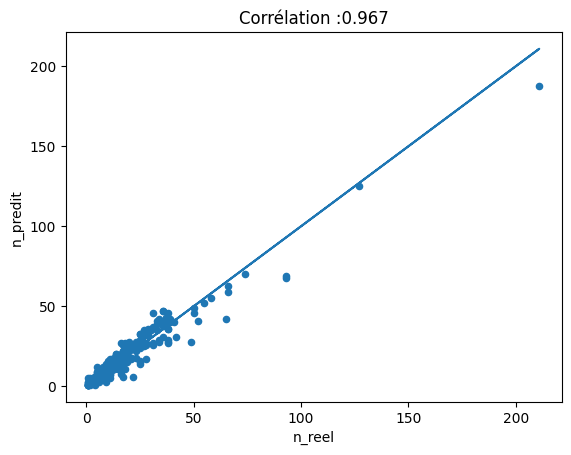

In [ ]:
dd = df.query(
    """
      conf==0.5 and slice_size==480 and overlap==200
    """
)
ax = dd.plot(kind='scatter', x='n_reel', y='n_predit')
ax.plot(dd["n_reel"], dd["n_reel"])
cor = "{:.3f}".format(dd["n_predit"].corr(dd['n_reel']))
ax.set_title("Corrélation :" + cor)

In [ ]:
noms_images = []
confs = []
nombres_predits = []
poids_predits = []
categories_predits = []
nombres_reels = []
poids_reels = []
categories_reels = []
overlap_pix = []
slc_size = []

file_name = "resultats_tuillage2.csv"
a = 1
for pred_msk_path, true_msk_path, img_p, lbl_p in tqdm.tqdm(zip(pred_masks, true_masks, images_p, labels_p), total=len(labels_p)):
  nom_img = img_p.split("/")[-1]

  if pred_msk_path.split("/")[-1] != true_msk_path.split("/")[-1]:
    print(pred_msk_path.split("/")[-1], true_msk_path.split("/")[-1])
  for conf in [0.1, 0.3, 0.5, 0.7]: # [0.1, 0.3, 0.5]
    for slice_size in [640]: # 480, 640 -> Next 640
      for overlap_pixels in [200, 300]: # [200, 300]
        # Prédire en utilisant YOLO
        nombre_predit, categorie_predit, poids_predit =  get_tilled_yolo_pred(
            model_path,
            img_p,
            iou=0.7,
            conf=conf,
            slice_size=slice_size,
            overlap_pixels=overlap_pixels,
            pred_size=slice_size,
            mask_path=pred_msk_path
            )


        # Nombre, dimension des fruits annotées
        masques_annotees = get_polygons(path_to_label_file=lbl_p, image_path=img_p)
        nombre_reel, categorie_reel, poids_reel =  get_true_number_fruit_type_weight(label_path=lbl_p, image_path=img_p, mask_p=true_msk_path)

        noms_images.append(nom_img)
        nombres_predits.append(nombre_predit)
        poids_predits.append(poids_predit)
        categories_predits.append(categorie_predit)
        nombres_reels.append(nombre_reel)
        poids_reels.append(poids_reel)
        categories_reels.append(categorie_reel)
        confs.append(conf)
        slc_size.append(slice_size)
        overlap_pix.append(overlap_pixels)

data = {
    "image": noms_images,
    "conf": confs,
    "n_predit": nombres_predits,
    "poids_predit": poids_predits,
    "cadtegorie_predit": categories_predits,
    "n_reel": nombres_reels,
    "poids_reel": poids_reels,
    "categorie_reel": categories_reels,
    "overlap": overlap_pix,
    "slice_size": slc_size
}

df = pd.DataFrame(data)
df.to_csv(save_folder + file_name, index=False)

In [ ]:
df.head()

image  conf  n_predit  \
0  BIG_11_CadreFruitNord_ArbreEch_1_V1_2022-03-26...   0.1         7   
1  BIG_11_CadreFruitNord_ArbreEch_1_V1_2022-03-26...   0.1         8   
2  BIG_11_CadreFruitNord_ArbreEch_1_V1_2022-03-26...   0.3         2   
3  BIG_11_CadreFruitNord_ArbreEch_1_V1_2022-03-26...   0.3         2   
4  BIG_11_CadreFruitNord_ArbreEch_1_V1_2022-03-26...   0.5         2   

   poids_predit cadtegorie_predit  n_reel  poids_reel categorie_reel  overlap  \
0          72.1             Ovale       2        20.6          Ovale      200   
1          82.4             Ovale       2        20.6          Ovale      300   
2          20.6             Ovale       2        20.6          Ovale      200   
3          20.6             Ovale       2        20.6          Ovale      300   
4          20.6             Ovale       2        20.6          Ovale      200   

   slice_size  
0         640  
1         640  
2         640  
3         640  
4         640

Text(0.5, 1.0, 'Corrélation :0.975')

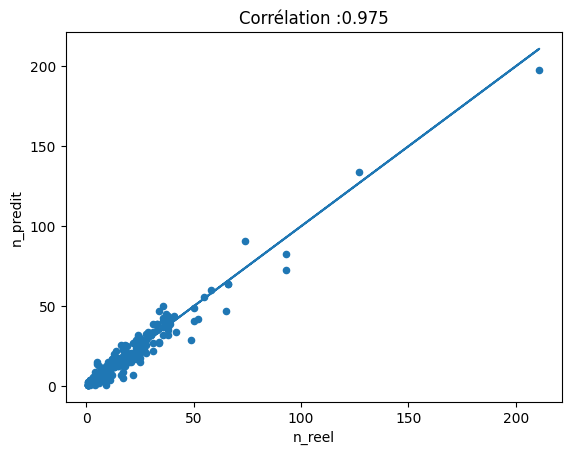

In [ ]:
dd = df.query(
    """
      conf==0.3 and slice_size==640 and overlap==200
    """
)
ax = dd.plot(kind='scatter', x='n_reel', y='n_predit')
ax.plot(dd["n_reel"], dd["n_reel"])
cor = "{:.3f}".format(dd["n_predit"].corr(dd['n_reel']))
ax.set_title("Corrélation :" + cor)

In [ ]:
df["n_reel"].corr(df["n_predit"])

0.9755105374258081

In [ ]:
df.head()

image  conf  n_predit  \
0  BIG_11_CadreFruitNord_ArbreEch_1_V1_2022-03-26...   0.3         2   
1  BIG_11_CadreFruitNord_ArbreEch_2_V1_2022-03-26...   0.3        20   
2  BIG_16_CadreFruitEst_ArbreEch_1_V1_2022-03-27.jpg   0.3        29   
3  BIG_16_CadreFruitOuest_ArbreEch_1_V1_2022-03-2...   0.3        23   
4  BIG_16_CadreFruitSud_ArbreEch_1_V1_2022-03-27.jpg   0.3         3   

   poids_predit cadtegorie_predit  n_reel  poids_reel categorie_reel  overlap  \
0          20.6             Ovale       2        20.6          Ovale      300   
1         206.0             Ovale      23       236.9          Ovale      300   
2         298.7             Ovale      28       288.4          Ovale      300   
3         236.9             Ovale      18       185.4          Ovale      300   
4          30.9             Ovale       2        20.6          Ovale      300   

   slice_size  
0         960  
1         960  
2         960  
3         960  
4         960

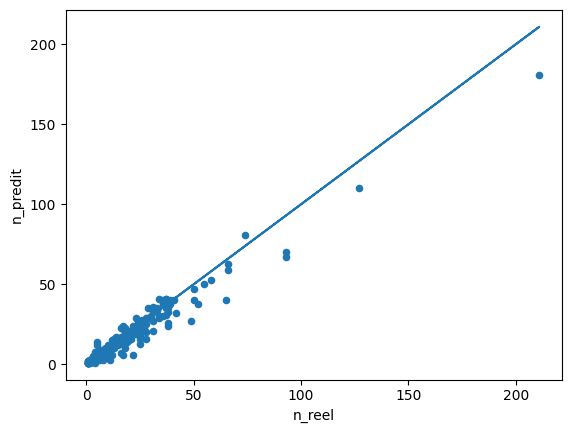

In [ ]:
ax = df1.plot(kind="scatter", x="n_reel", y="n_predit")
ax.plot(df1["n_reel"], df1["n_reel"])

In [ ]:
model_path = "/content/drive/MyDrive/ModelsTraining/ModelsYOLOFinal/ComparaisonModels/yolov8s-seg/weights/best.pt"
model = YOLO(model_path)
# pred_masks = sorted(glob.glob("/content/drive/MyDrive/ModelsTraining/ModelsYOLOFinal/atf-1/valid/cadrespredits/*.png"))
# true_masks = sorted(glob.glob("/content/drive/MyDrive/ModelsTraining/ModelsYOLOFinal/atf-1/valid/cadrereels/*.png"))
images_p = sorted(glob.glob("/content/drive/MyDrive/ModelsTraining/ModelsYOLOFinal/atf-1/valid/images/*.jpg")) + sorted(glob.glob("/content/drive/MyDrive/ModelsTraining/ModelsYOLOFinal/atf-1/train/images/*.jpg"))
labels_p = sorted(glob.glob("/content/drive/MyDrive/ModelsTraining/ModelsYOLOFinal/atf-1/valid/labels/*.txt")) + sorted(glob.glob("/content/drive/MyDrive/ModelsTraining/ModelsYOLOFinal/atf-1/train/labels/*.txt"))
save_folder = "/content/drive/MyDrive/ModelsTraining/ModelsYOLOFinal/CorrelationCompatage/"

In [ ]:
images, _, labels, _ = train_test_split(images_p, labels_p, train_size=800 / 836, random_state=10, shuffle=True)

In [ ]:
noms_images = []
confs = []
nombres_predits = []
poids_predits = []
categories_predits = []
nombres_reels = []
poids_reels = []
categories_reels = []
save_fold = "/content/drive/MyDrive/ModelsTraining/ModelsYOLOFinal/ComparaisonModels/SlicingEvaluation/RatiosTailleFruits/TailleInitEtudeforme"
file_name = "resultats_sans_tuillage.csv"
a = 1
for img_p, lbl_p in tqdm.tqdm(zip(images, labels), total=len(labels)):
  nom_img = img_p.split("/")[-1]

  for conf in [0.3]: # [0.1, 0.3, 0.5]:
    for img_size in ["Initial"]:

      # Prédire en utilisant YOLO
      nombre_predit, categorie_predit, poids_predit =  get_yolo_pred(model, img_p, img_size=img_size, conf=conf, iou=0.7, mask_path=None, save_fold=save_fold)


      # Nombre, dimension des fruits annotées
      masques_annotees = get_polygons(path_to_label_file=lbl_p, image_path=img_p)
      nombre_reel, categorie_reel, poids_reel =  get_true_number_fruit_type_weight(label_path=lbl_p, image_path=img_p, mask_p=None, save_fold=save_fold)

      noms_images.append(nom_img)
      nombres_predits.append(nombre_predit)
      poids_predits.append(poids_predit)
      categories_predits.append(categorie_predit)
      nombres_reels.append(nombre_reel)
      poids_reels.append(poids_reel)
      categories_reels.append(categorie_reel)
      confs.append(conf)

data = {
    "image": noms_images,
    "conf": confs,
    "n_predit": nombres_predits,
    "poids_predit": poids_predits,
    "cadtegorie_predit": categories_predits,
    "n_reel": nombres_reels,
    "poids_reel": poids_reels,
    "categorie_reel": categories_reels
}

df = pd.DataFrame(data)
df.to_csv(save_fold + file_name, index=False)

  0%|          | 0/800 [00:00<?, ?it/s]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


  0%|          | 1/800 [00:00<07:16,  1.83it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  0%|          | 2/800 [00:01<07:42,  1.73it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  0%|          | 3/800 [00:01<05:36,  2.37it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  0%|          | 4/800 [00:01<04:31,  2.93it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  1%|          | 5/800 [00:02<05:58,  2.22it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  1%|          | 6/800 [00:02<05:40,  2.33it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  1%|          | 7/800 [00:03<05:35,  2.36it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  1%|          | 8/800 [00:03<04:47,  2.75it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  1%|          | 9/800 [00:04<06:34,  2.00it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  1%|▏         | 10/800 [00:04<06:18,  2.09it/s]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


  1%|▏         | 11/800 [00:04<05:53,  2.23it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  2%|▏         | 12/800 [00:05<06:09,  2.13it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  2%|▏         | 13/800 [00:05<05:06,  2.57it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  2%|▏         | 14/800 [00:05<04:42,  2.78it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  2%|▏         | 15/800 [00:06<06:54,  1.89it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  2%|▏         | 16/800 [00:07<05:41,  2.30it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  2%|▏         | 17/800 [00:07<06:06,  2.14it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  2%|▏         | 18/800 [00:08<07:00,  1.86it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  2%|▏         | 19/800 [00:08<05:56,  2.19it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  2%|▎         | 20/800 [00:08<05:44,  2.26it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  3%|▎         | 21/800 [00:09<04:56,  2.63it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  3%|▎         | 22/800 [00:09<05:30,  2.35it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  3%|▎         | 23/800 [00:10<05:47,  2.23it/s]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


  3%|▎         | 24/800 [00:10<06:17,  2.06it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  3%|▎         | 25/800 [00:11<07:07,  1.81it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  3%|▎         | 26/800 [00:12<07:32,  1.71it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  3%|▎         | 27/800 [00:12<07:54,  1.63it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  4%|▎         | 28/800 [00:13<07:45,  1.66it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  4%|▎         | 29/800 [00:13<06:59,  1.84it/s]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


  4%|▍         | 30/800 [00:14<05:55,  2.16it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  4%|▍         | 31/800 [00:14<06:17,  2.04it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  4%|▍         | 32/800 [00:15<06:22,  2.01it/s]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


  4%|▍         | 33/800 [00:16<07:38,  1.67it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  4%|▍         | 34/800 [00:16<07:53,  1.62it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  4%|▍         | 35/800 [00:17<07:24,  1.72it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  4%|▍         | 36/800 [00:17<06:48,  1.87it/s]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


  5%|▍         | 37/800 [00:18<07:00,  1.82it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  5%|▍         | 38/800 [00:18<07:01,  1.81it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  5%|▍         | 39/800 [00:19<07:05,  1.79it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  5%|▌         | 40/800 [00:19<06:35,  1.92it/s]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


  5%|▌         | 41/800 [00:20<07:53,  1.60it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  5%|▌         | 42/800 [00:21<10:10,  1.24it/s]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


  5%|▌         | 43/800 [00:22<10:37,  1.19it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  6%|▌         | 44/800 [00:23<10:42,  1.18it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  6%|▌         | 45/800 [00:25<14:07,  1.12s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  6%|▌         | 46/800 [00:26<13:44,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


  6%|▌         | 47/800 [00:27<13:54,  1.11s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


  6%|▌         | 48/800 [00:28<13:42,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  6%|▌         | 49/800 [00:29<13:42,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


  6%|▋         | 50/800 [00:30<14:00,  1.12s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  6%|▋         | 51/800 [00:31<13:39,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  6%|▋         | 52/800 [00:32<12:30,  1.00s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  7%|▋         | 53/800 [00:34<13:40,  1.10s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


  7%|▋         | 54/800 [00:35<16:47,  1.35s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


  7%|▋         | 55/800 [00:36<15:02,  1.21s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  7%|▋         | 56/800 [00:38<15:15,  1.23s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  7%|▋         | 57/800 [00:39<16:04,  1.30s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


  7%|▋         | 58/800 [00:40<14:48,  1.20s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


  7%|▋         | 59/800 [00:43<20:55,  1.69s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  8%|▊         | 60/800 [00:44<18:31,  1.50s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  8%|▊         | 61/800 [00:45<18:28,  1.50s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  8%|▊         | 62/800 [00:47<16:51,  1.37s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  8%|▊         | 63/800 [00:47<15:07,  1.23s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


  8%|▊         | 64/800 [00:48<13:24,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  8%|▊         | 65/800 [00:49<13:13,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  8%|▊         | 66/800 [00:50<13:30,  1.10s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  8%|▊         | 67/800 [00:52<14:25,  1.18s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  8%|▊         | 68/800 [00:53<14:18,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  9%|▊         | 69/800 [00:54<14:16,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


  9%|▉         | 70/800 [00:55<12:53,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  9%|▉         | 71/800 [00:56<11:59,  1.01it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  9%|▉         | 72/800 [00:57<12:41,  1.05s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  9%|▉         | 73/800 [00:58<14:15,  1.18s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


  9%|▉         | 74/800 [00:59<12:40,  1.05s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


  9%|▉         | 75/800 [01:00<12:03,  1.00it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 10%|▉         | 76/800 [01:01<11:43,  1.03it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 10%|▉         | 77/800 [01:02<12:34,  1.04s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 10%|▉         | 78/800 [01:03<12:29,  1.04s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 10%|▉         | 79/800 [01:04<12:36,  1.05s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 10%|█         | 80/800 [01:05<12:23,  1.03s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 10%|█         | 81/800 [01:06<12:04,  1.01s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 10%|█         | 82/800 [01:07<11:32,  1.04it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 10%|█         | 83/800 [01:08<11:40,  1.02it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 10%|█         | 84/800 [01:09<12:01,  1.01s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 11%|█         | 85/800 [01:10<11:34,  1.03it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 11%|█         | 86/800 [01:12<13:53,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 11%|█         | 87/800 [01:13<14:52,  1.25s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 11%|█         | 88/800 [01:14<14:10,  1.19s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 11%|█         | 89/800 [01:15<13:19,  1.12s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 11%|█▏        | 90/800 [01:16<13:28,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 11%|█▏        | 91/800 [01:18<13:47,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 12%|█▏        | 92/800 [01:19<13:49,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 12%|█▏        | 93/800 [01:20<13:33,  1.15s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 12%|█▏        | 94/800 [01:21<12:55,  1.10s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 12%|█▏        | 95/800 [01:22<12:27,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 12%|█▏        | 96/800 [01:23<11:33,  1.02it/s]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 12%|█▏        | 97/800 [01:24<12:48,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 12%|█▏        | 98/800 [01:25<12:01,  1.03s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 12%|█▏        | 99/800 [01:26<11:09,  1.05it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 12%|█▎        | 100/800 [01:26<10:55,  1.07it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 13%|█▎        | 101/800 [01:28<11:22,  1.02it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 13%|█▎        | 102/800 [01:28<11:00,  1.06it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 13%|█▎        | 103/800 [01:30<12:32,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 13%|█▎        | 104/800 [01:31<13:44,  1.18s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 13%|█▎        | 105/800 [01:32<13:10,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 13%|█▎        | 106/800 [01:34<14:15,  1.23s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 13%|█▎        | 107/800 [01:35<13:37,  1.18s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 14%|█▎        | 108/800 [01:36<13:38,  1.18s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 14%|█▎        | 109/800 [01:38<16:51,  1.46s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 14%|█▍        | 110/800 [01:45<35:59,  3.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 14%|█▍        | 111/800 [01:46<28:40,  2.50s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 14%|█▍        | 112/800 [01:47<22:53,  2.00s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 14%|█▍        | 113/800 [01:48<19:46,  1.73s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 14%|█▍        | 114/800 [01:50<18:59,  1.66s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 14%|█▍        | 115/800 [01:51<17:01,  1.49s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 14%|█▍        | 116/800 [01:52<16:20,  1.43s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 15%|█▍        | 117/800 [01:54<19:31,  1.72s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 15%|█▍        | 118/800 [01:55<16:23,  1.44s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 15%|█▍        | 119/800 [01:56<14:40,  1.29s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 15%|█▌        | 120/800 [01:57<12:52,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 15%|█▌        | 121/800 [01:58<12:16,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 15%|█▌        | 122/800 [01:59<12:36,  1.12s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 15%|█▌        | 123/800 [02:00<12:40,  1.12s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 16%|█▌        | 124/800 [02:01<12:45,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 16%|█▌        | 125/800 [02:02<12:59,  1.15s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 16%|█▌        | 126/800 [02:04<13:36,  1.21s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 16%|█▌        | 127/800 [02:05<13:07,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 16%|█▌        | 128/800 [02:06<11:23,  1.02s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 16%|█▌        | 129/800 [02:07<12:43,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 16%|█▋        | 130/800 [02:08<13:31,  1.21s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 16%|█▋        | 131/800 [02:10<13:47,  1.24s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 16%|█▋        | 132/800 [02:11<14:23,  1.29s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 17%|█▋        | 133/800 [02:12<14:33,  1.31s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 17%|█▋        | 134/800 [02:13<13:09,  1.19s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 17%|█▋        | 135/800 [02:14<12:52,  1.16s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 17%|█▋        | 136/800 [02:16<13:22,  1.21s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 17%|█▋        | 137/800 [02:17<12:52,  1.16s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 17%|█▋        | 138/800 [02:18<11:51,  1.07s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 17%|█▋        | 139/800 [02:19<11:44,  1.07s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 18%|█▊        | 140/800 [02:20<11:54,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 18%|█▊        | 141/800 [02:21<11:42,  1.07s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 18%|█▊        | 142/800 [02:22<11:15,  1.03s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 18%|█▊        | 143/800 [02:23<10:31,  1.04it/s]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 18%|█▊        | 144/800 [02:24<10:30,  1.04it/s]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 18%|█▊        | 145/800 [02:25<10:46,  1.01it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 18%|█▊        | 146/800 [02:26<11:54,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 18%|█▊        | 147/800 [02:27<11:39,  1.07s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 18%|█▊        | 148/800 [02:28<11:30,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 19%|█▊        | 149/800 [02:29<10:44,  1.01it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 19%|█▉        | 150/800 [02:30<10:38,  1.02it/s]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 19%|█▉        | 151/800 [02:32<13:51,  1.28s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 19%|█▉        | 152/800 [02:33<13:10,  1.22s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 19%|█▉        | 153/800 [02:34<12:56,  1.20s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 19%|█▉        | 154/800 [02:36<13:50,  1.29s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 19%|█▉        | 155/800 [02:37<13:36,  1.27s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 20%|█▉        | 156/800 [02:38<12:21,  1.15s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 20%|█▉        | 157/800 [02:39<12:00,  1.12s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 20%|█▉        | 158/800 [02:40<11:08,  1.04s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 20%|█▉        | 159/800 [02:40<10:47,  1.01s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 20%|██        | 160/800 [02:41<10:38,  1.00it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 20%|██        | 161/800 [02:43<10:56,  1.03s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 20%|██        | 162/800 [02:44<10:57,  1.03s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 20%|██        | 163/800 [02:45<11:05,  1.05s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 20%|██        | 164/800 [02:45<10:23,  1.02it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 21%|██        | 165/800 [02:47<11:01,  1.04s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 21%|██        | 166/800 [02:48<12:53,  1.22s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 21%|██        | 167/800 [02:49<12:23,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 21%|██        | 168/800 [02:50<12:15,  1.16s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 21%|██        | 169/800 [02:52<12:53,  1.23s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 21%|██▏       | 170/800 [02:53<13:15,  1.26s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 21%|██▏       | 171/800 [02:54<12:59,  1.24s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 22%|██▏       | 172/800 [02:55<11:43,  1.12s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 22%|██▏       | 173/800 [02:56<11:21,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 22%|██▏       | 174/800 [02:57<11:18,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 22%|██▏       | 175/800 [02:58<11:06,  1.07s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 22%|██▏       | 176/800 [02:59<11:15,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 22%|██▏       | 177/800 [03:01<11:56,  1.15s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 22%|██▏       | 178/800 [03:02<11:20,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 22%|██▏       | 179/800 [03:03<11:00,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 22%|██▎       | 180/800 [03:04<11:12,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 23%|██▎       | 181/800 [03:05<10:46,  1.04s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 23%|██▎       | 182/800 [03:06<10:25,  1.01s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 23%|██▎       | 183/800 [03:07<10:16,  1.00it/s]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 23%|██▎       | 184/800 [03:08<09:46,  1.05it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 23%|██▎       | 185/800 [03:09<09:55,  1.03it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 23%|██▎       | 186/800 [03:10<09:55,  1.03it/s]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 23%|██▎       | 187/800 [03:11<10:36,  1.04s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 24%|██▎       | 188/800 [03:12<10:22,  1.02s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 24%|██▎       | 189/800 [03:13<10:30,  1.03s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 24%|██▍       | 190/800 [03:14<10:10,  1.00s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 24%|██▍       | 191/800 [03:15<09:33,  1.06it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 24%|██▍       | 192/800 [03:16<12:16,  1.21s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 24%|██▍       | 193/800 [03:18<12:41,  1.25s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 24%|██▍       | 194/800 [03:19<12:05,  1.20s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 24%|██▍       | 195/800 [03:20<12:07,  1.20s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 24%|██▍       | 196/800 [03:21<11:05,  1.10s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 25%|██▍       | 197/800 [03:22<11:25,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 25%|██▍       | 198/800 [03:24<12:20,  1.23s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 25%|██▍       | 199/800 [03:25<12:11,  1.22s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 25%|██▌       | 200/800 [03:26<12:21,  1.24s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 25%|██▌       | 201/800 [03:27<12:30,  1.25s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 25%|██▌       | 202/800 [03:28<12:01,  1.21s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 25%|██▌       | 203/800 [03:29<11:39,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 26%|██▌       | 204/800 [03:30<10:45,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 26%|██▌       | 205/800 [03:31<10:13,  1.03s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 26%|██▌       | 206/800 [03:32<10:17,  1.04s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 26%|██▌       | 207/800 [03:33<10:01,  1.01s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 26%|██▌       | 208/800 [03:34<10:02,  1.02s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 26%|██▌       | 209/800 [03:35<10:26,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 26%|██▋       | 210/800 [03:37<10:29,  1.07s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 26%|██▋       | 211/800 [03:37<09:54,  1.01s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 26%|██▋       | 212/800 [03:39<10:35,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 27%|██▋       | 213/800 [03:40<11:31,  1.18s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 27%|██▋       | 214/800 [03:42<15:08,  1.55s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 27%|██▋       | 215/800 [03:43<13:17,  1.36s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 27%|██▋       | 216/800 [03:44<12:17,  1.26s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 27%|██▋       | 217/800 [03:45<11:17,  1.16s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 27%|██▋       | 218/800 [03:46<10:36,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 27%|██▋       | 219/800 [03:48<11:02,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 28%|██▊       | 220/800 [03:48<10:16,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 28%|██▊       | 221/800 [03:50<10:54,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 28%|██▊       | 222/800 [03:51<11:40,  1.21s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 28%|██▊       | 223/800 [03:52<11:39,  1.21s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 28%|██▊       | 224/800 [03:54<11:50,  1.23s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 28%|██▊       | 225/800 [03:55<11:06,  1.16s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 28%|██▊       | 226/800 [03:56<11:03,  1.16s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 28%|██▊       | 227/800 [03:57<10:02,  1.05s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 28%|██▊       | 228/800 [03:58<10:10,  1.07s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 29%|██▊       | 229/800 [03:59<11:01,  1.16s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 29%|██▉       | 230/800 [04:00<10:10,  1.07s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 29%|██▉       | 231/800 [04:07<28:41,  3.03s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 29%|██▉       | 232/800 [04:09<23:41,  2.50s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 29%|██▉       | 233/800 [04:10<19:39,  2.08s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 29%|██▉       | 234/800 [04:11<16:27,  1.74s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 29%|██▉       | 235/800 [04:12<13:44,  1.46s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 30%|██▉       | 236/800 [04:12<11:59,  1.28s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 30%|██▉       | 237/800 [04:14<11:35,  1.24s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 30%|██▉       | 238/800 [04:14<10:16,  1.10s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 30%|██▉       | 239/800 [04:15<09:59,  1.07s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 30%|███       | 240/800 [04:17<11:09,  1.20s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 30%|███       | 241/800 [04:19<12:36,  1.35s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 30%|███       | 242/800 [04:20<12:03,  1.30s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 30%|███       | 243/800 [04:21<11:13,  1.21s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 30%|███       | 244/800 [04:22<10:30,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 31%|███       | 245/800 [04:23<10:02,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 31%|███       | 246/800 [04:24<09:27,  1.02s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 31%|███       | 247/800 [04:25<09:46,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 31%|███       | 248/800 [04:26<09:23,  1.02s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 31%|███       | 249/800 [04:27<09:07,  1.01it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 31%|███▏      | 250/800 [04:28<09:02,  1.01it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 31%|███▏      | 251/800 [04:36<30:21,  3.32s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 32%|███▏      | 252/800 [04:37<23:44,  2.60s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 32%|███▏      | 253/800 [04:39<21:21,  2.34s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 32%|███▏      | 254/800 [04:40<18:02,  1.98s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 32%|███▏      | 255/800 [04:41<15:02,  1.66s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 32%|███▏      | 256/800 [04:42<14:28,  1.60s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 32%|███▏      | 257/800 [04:43<12:51,  1.42s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 32%|███▏      | 258/800 [04:45<12:49,  1.42s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 32%|███▏      | 259/800 [05:42<2:44:37, 18.26s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 32%|███▎      | 260/800 [05:44<1:58:23, 13.15s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 33%|███▎      | 261/800 [05:45<1:25:06,  9.47s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 33%|███▎      | 262/800 [05:46<1:02:08,  6.93s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 33%|███▎      | 263/800 [05:47<45:57,  5.13s/it]  

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 33%|███▎      | 264/800 [05:48<34:57,  3.91s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 33%|███▎      | 265/800 [05:49<27:45,  3.11s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 33%|███▎      | 266/800 [05:50<23:50,  2.68s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 33%|███▎      | 267/800 [05:51<18:55,  2.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 34%|███▎      | 268/800 [05:53<16:20,  1.84s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 34%|███▎      | 269/800 [05:54<15:24,  1.74s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 34%|███▍      | 270/800 [05:55<13:55,  1.58s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 34%|███▍      | 271/800 [05:56<12:07,  1.38s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 34%|███▍      | 272/800 [05:57<11:23,  1.29s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 34%|███▍      | 273/800 [05:58<10:45,  1.23s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 34%|███▍      | 274/800 [06:01<14:45,  1.68s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 34%|███▍      | 275/800 [06:02<12:58,  1.48s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 34%|███▍      | 276/800 [06:03<12:17,  1.41s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 35%|███▍      | 277/800 [06:04<11:43,  1.34s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 35%|███▍      | 278/800 [06:06<11:28,  1.32s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 35%|███▍      | 279/800 [06:07<10:23,  1.20s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 35%|███▌      | 280/800 [06:08<11:18,  1.30s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 35%|███▌      | 281/800 [06:09<10:07,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 35%|███▌      | 282/800 [06:10<09:04,  1.05s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 35%|███▌      | 283/800 [06:11<08:39,  1.01s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 36%|███▌      | 284/800 [06:12<09:21,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 36%|███▌      | 285/800 [06:14<11:51,  1.38s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 36%|███▌      | 286/800 [06:16<13:55,  1.63s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 36%|███▌      | 287/800 [06:17<12:13,  1.43s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 36%|███▌      | 288/800 [06:18<10:58,  1.29s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 36%|███▌      | 289/800 [06:20<12:19,  1.45s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 36%|███▋      | 290/800 [06:21<12:14,  1.44s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 36%|███▋      | 291/800 [06:22<11:14,  1.32s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 36%|███▋      | 292/800 [06:23<10:06,  1.19s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 37%|███▋      | 293/800 [06:24<09:08,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 37%|███▋      | 294/800 [06:25<08:34,  1.02s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 37%|███▋      | 295/800 [06:26<09:23,  1.12s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 37%|███▋      | 296/800 [06:27<08:55,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 37%|███▋      | 297/800 [06:29<09:32,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 37%|███▋      | 298/800 [06:30<09:31,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 37%|███▋      | 299/800 [06:31<09:07,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 38%|███▊      | 300/800 [06:32<08:54,  1.07s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 38%|███▊      | 301/800 [06:33<09:03,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 38%|███▊      | 302/800 [06:34<08:58,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 38%|███▊      | 303/800 [06:35<08:23,  1.01s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 38%|███▊      | 304/800 [06:36<07:56,  1.04it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 38%|███▊      | 305/800 [06:37<07:47,  1.06it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 38%|███▊      | 306/800 [06:38<09:18,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 38%|███▊      | 307/800 [06:39<08:52,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 38%|███▊      | 308/800 [06:40<08:30,  1.04s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 39%|███▊      | 309/800 [06:41<08:11,  1.00s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 39%|███▉      | 310/800 [06:42<08:26,  1.03s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 39%|███▉      | 311/800 [06:44<09:23,  1.15s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 39%|███▉      | 312/800 [06:44<08:42,  1.07s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 39%|███▉      | 313/800 [06:46<09:10,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 39%|███▉      | 314/800 [06:47<09:02,  1.12s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 39%|███▉      | 315/800 [06:48<09:07,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 40%|███▉      | 316/800 [06:49<09:36,  1.19s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 40%|███▉      | 317/800 [06:50<09:12,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 40%|███▉      | 318/800 [06:51<09:17,  1.16s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 40%|███▉      | 319/800 [06:53<09:24,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 40%|████      | 320/800 [06:54<08:53,  1.11s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 40%|████      | 321/800 [06:55<09:04,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 40%|████      | 322/800 [06:56<08:42,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 40%|████      | 323/800 [06:57<08:16,  1.04s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 40%|████      | 324/800 [06:58<08:35,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 41%|████      | 325/800 [06:59<08:28,  1.07s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 41%|████      | 326/800 [07:00<07:41,  1.03it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 41%|████      | 327/800 [07:01<08:42,  1.11s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 41%|████      | 328/800 [07:02<08:29,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 41%|████      | 329/800 [07:04<09:32,  1.22s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 41%|████▏     | 330/800 [07:05<09:28,  1.21s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 41%|████▏     | 331/800 [07:06<08:47,  1.12s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 42%|████▏     | 332/800 [07:07<08:36,  1.10s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 42%|████▏     | 333/800 [07:08<09:22,  1.20s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 42%|████▏     | 334/800 [07:10<09:18,  1.20s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 42%|████▏     | 335/800 [07:11<09:20,  1.21s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 42%|████▏     | 336/800 [07:12<08:31,  1.10s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 42%|████▏     | 337/800 [07:13<08:09,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 42%|████▏     | 338/800 [07:13<07:40,  1.00it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 42%|████▏     | 339/800 [07:15<08:21,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 42%|████▎     | 340/800 [07:16<08:15,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 43%|████▎     | 341/800 [07:17<08:48,  1.15s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 43%|████▎     | 342/800 [07:19<09:31,  1.25s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 43%|████▎     | 343/800 [07:19<08:38,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 43%|████▎     | 344/800 [07:21<10:30,  1.38s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 43%|████▎     | 345/800 [07:22<09:21,  1.23s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 43%|████▎     | 346/800 [07:23<08:25,  1.11s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 43%|████▎     | 347/800 [07:25<09:29,  1.26s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 44%|████▎     | 348/800 [07:26<09:06,  1.21s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 44%|████▎     | 349/800 [07:27<08:08,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 44%|████▍     | 350/800 [07:28<08:18,  1.11s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 44%|████▍     | 351/800 [07:29<08:02,  1.07s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 44%|████▍     | 352/800 [07:30<08:35,  1.15s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 44%|████▍     | 353/800 [07:31<08:06,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 44%|████▍     | 354/800 [07:32<07:59,  1.07s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 44%|████▍     | 355/800 [07:33<08:11,  1.10s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 44%|████▍     | 356/800 [07:34<08:23,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 45%|████▍     | 357/800 [07:35<07:58,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 45%|████▍     | 358/800 [07:36<07:49,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 45%|████▍     | 359/800 [07:37<07:27,  1.01s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 45%|████▌     | 360/800 [07:39<08:03,  1.10s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 45%|████▌     | 361/800 [07:40<07:57,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 45%|████▌     | 362/800 [07:40<07:21,  1.01s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 45%|████▌     | 363/800 [07:42<07:33,  1.04s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 46%|████▌     | 364/800 [07:43<07:48,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 46%|████▌     | 365/800 [07:45<09:43,  1.34s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 46%|████▌     | 366/800 [07:46<08:51,  1.22s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 46%|████▌     | 367/800 [07:47<08:11,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 46%|████▌     | 368/800 [07:48<08:09,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 46%|████▌     | 369/800 [07:49<08:11,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 46%|████▋     | 370/800 [07:50<07:53,  1.10s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 46%|████▋     | 371/800 [07:51<08:09,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 46%|████▋     | 372/800 [07:52<07:40,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 47%|████▋     | 373/800 [07:53<07:31,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 47%|████▋     | 374/800 [07:54<08:12,  1.16s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 47%|████▋     | 375/800 [07:55<07:30,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 47%|████▋     | 376/800 [07:56<07:42,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 47%|████▋     | 377/800 [07:58<07:58,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 47%|████▋     | 378/800 [07:59<08:14,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 47%|████▋     | 379/800 [08:01<09:02,  1.29s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 48%|████▊     | 380/800 [08:02<08:34,  1.23s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 48%|████▊     | 381/800 [08:03<08:30,  1.22s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 48%|████▊     | 382/800 [08:04<08:22,  1.20s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 48%|████▊     | 383/800 [08:05<07:52,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 48%|████▊     | 384/800 [08:06<07:27,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 48%|████▊     | 385/800 [08:07<08:26,  1.22s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 48%|████▊     | 386/800 [08:08<07:52,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 48%|████▊     | 387/800 [08:10<08:03,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 48%|████▊     | 388/800 [08:11<07:51,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 49%|████▊     | 389/800 [08:12<08:01,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 49%|████▉     | 390/800 [08:13<08:45,  1.28s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 49%|████▉     | 391/800 [08:15<09:05,  1.33s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 49%|████▉     | 392/800 [08:16<08:36,  1.27s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 49%|████▉     | 393/800 [08:17<08:18,  1.22s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 49%|████▉     | 394/800 [08:18<07:52,  1.16s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 49%|████▉     | 395/800 [08:19<07:22,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 50%|████▉     | 396/800 [08:20<07:12,  1.07s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 50%|████▉     | 397/800 [08:21<06:55,  1.03s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 50%|████▉     | 398/800 [08:22<07:36,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 50%|████▉     | 399/800 [08:23<06:59,  1.05s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 50%|█████     | 400/800 [08:26<09:31,  1.43s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 50%|█████     | 401/800 [08:27<08:41,  1.31s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 50%|█████     | 402/800 [08:28<07:59,  1.20s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 50%|█████     | 403/800 [08:29<08:29,  1.28s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 50%|█████     | 404/800 [08:30<07:55,  1.20s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 51%|█████     | 405/800 [08:31<07:16,  1.10s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 51%|█████     | 406/800 [08:32<07:16,  1.11s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 51%|█████     | 407/800 [08:33<07:24,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 51%|█████     | 408/800 [08:34<07:04,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 51%|█████     | 409/800 [08:35<06:54,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 51%|█████▏    | 410/800 [08:37<07:52,  1.21s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 51%|█████▏    | 411/800 [08:38<07:28,  1.15s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 52%|█████▏    | 412/800 [08:39<08:18,  1.29s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 52%|█████▏    | 413/800 [08:40<07:54,  1.23s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 52%|█████▏    | 414/800 [08:41<07:03,  1.10s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 52%|█████▏    | 415/800 [08:42<06:46,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 52%|█████▏    | 416/800 [08:44<08:43,  1.36s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 52%|█████▏    | 417/800 [08:45<07:55,  1.24s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 52%|█████▏    | 418/800 [08:46<07:19,  1.15s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 52%|█████▏    | 419/800 [08:47<06:54,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 52%|█████▎    | 420/800 [08:48<06:33,  1.04s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 53%|█████▎    | 421/800 [08:49<06:40,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 53%|█████▎    | 422/800 [08:51<07:34,  1.20s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 53%|█████▎    | 423/800 [08:52<07:28,  1.19s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 53%|█████▎    | 424/800 [08:53<07:30,  1.20s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 53%|█████▎    | 425/800 [08:54<07:08,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 53%|█████▎    | 426/800 [08:56<07:42,  1.24s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 53%|█████▎    | 427/800 [08:56<07:00,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 54%|█████▎    | 428/800 [08:58<06:59,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 54%|█████▎    | 429/800 [08:59<06:44,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 54%|█████▍    | 430/800 [08:59<06:16,  1.02s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 54%|█████▍    | 431/800 [09:00<06:03,  1.02it/s]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 54%|█████▍    | 432/800 [09:01<06:00,  1.02it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 54%|█████▍    | 433/800 [09:02<06:00,  1.02it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 54%|█████▍    | 434/800 [09:03<05:29,  1.11it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 54%|█████▍    | 435/800 [09:04<06:21,  1.04s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 55%|█████▍    | 436/800 [09:06<07:15,  1.20s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 55%|█████▍    | 437/800 [09:07<06:42,  1.11s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 55%|█████▍    | 438/800 [09:08<06:34,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 55%|█████▍    | 439/800 [09:09<06:03,  1.01s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 55%|█████▌    | 440/800 [09:10<06:05,  1.02s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 55%|█████▌    | 441/800 [09:11<05:38,  1.06it/s]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 55%|█████▌    | 442/800 [09:12<06:00,  1.01s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 55%|█████▌    | 443/800 [09:13<06:25,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 56%|█████▌    | 444/800 [09:14<06:17,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 56%|█████▌    | 445/800 [09:15<06:17,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 56%|█████▌    | 446/800 [09:17<07:45,  1.31s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 56%|█████▌    | 447/800 [09:18<07:32,  1.28s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 56%|█████▌    | 448/800 [09:20<07:44,  1.32s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 56%|█████▌    | 449/800 [09:21<07:51,  1.34s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 56%|█████▋    | 450/800 [09:22<07:11,  1.23s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 56%|█████▋    | 451/800 [09:23<06:41,  1.15s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 56%|█████▋    | 452/800 [09:24<06:46,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 57%|█████▋    | 453/800 [09:25<06:33,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 57%|█████▋    | 454/800 [09:27<07:11,  1.25s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 57%|█████▋    | 455/800 [09:27<06:32,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 57%|█████▋    | 456/800 [09:28<05:55,  1.03s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 57%|█████▋    | 457/800 [09:29<05:41,  1.01it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 57%|█████▋    | 458/800 [09:30<05:58,  1.05s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 57%|█████▋    | 459/800 [09:32<07:32,  1.33s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 57%|█████▊    | 460/800 [09:34<07:51,  1.39s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 58%|█████▊    | 461/800 [09:35<07:27,  1.32s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 58%|█████▊    | 462/800 [09:36<06:53,  1.22s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 58%|█████▊    | 463/800 [09:37<06:25,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 58%|█████▊    | 464/800 [09:38<06:24,  1.15s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 58%|█████▊    | 465/800 [09:39<06:11,  1.11s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 58%|█████▊    | 466/800 [09:40<05:43,  1.03s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 58%|█████▊    | 467/800 [09:41<06:01,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 58%|█████▊    | 468/800 [09:42<05:47,  1.05s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 59%|█████▊    | 469/800 [09:43<05:45,  1.04s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 59%|█████▉    | 470/800 [09:44<05:41,  1.04s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 59%|█████▉    | 471/800 [09:45<05:49,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 59%|█████▉    | 472/800 [09:48<07:38,  1.40s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 59%|█████▉    | 473/800 [09:49<07:38,  1.40s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 59%|█████▉    | 474/800 [09:50<07:12,  1.33s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 59%|█████▉    | 475/800 [09:52<08:29,  1.57s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 60%|█████▉    | 476/800 [09:53<07:47,  1.44s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 60%|█████▉    | 477/800 [09:54<06:39,  1.24s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 60%|█████▉    | 478/800 [09:56<06:57,  1.30s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 60%|█████▉    | 479/800 [09:57<06:22,  1.19s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 60%|██████    | 480/800 [09:58<06:30,  1.22s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 60%|██████    | 481/800 [09:59<06:31,  1.23s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 60%|██████    | 482/800 [10:00<06:06,  1.15s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 60%|██████    | 483/800 [10:01<05:48,  1.10s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 60%|██████    | 484/800 [10:02<05:40,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 61%|██████    | 485/800 [10:03<05:46,  1.10s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 61%|██████    | 486/800 [10:04<05:40,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 61%|██████    | 487/800 [10:06<06:06,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 61%|██████    | 488/800 [10:07<05:49,  1.12s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 61%|██████    | 489/800 [10:08<05:29,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 61%|██████▏   | 490/800 [10:08<05:05,  1.02it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 61%|██████▏   | 491/800 [10:09<04:42,  1.09it/s]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 62%|██████▏   | 492/800 [10:10<05:02,  1.02it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 62%|██████▏   | 493/800 [10:11<04:49,  1.06it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 62%|██████▏   | 494/800 [10:12<05:05,  1.00it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 62%|██████▏   | 495/800 [10:13<05:06,  1.01s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 62%|██████▏   | 496/800 [10:16<07:03,  1.39s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 62%|██████▏   | 497/800 [10:17<07:45,  1.54s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 62%|██████▏   | 498/800 [10:18<07:02,  1.40s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 62%|██████▏   | 499/800 [10:19<06:26,  1.28s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 62%|██████▎   | 500/800 [10:20<05:55,  1.19s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 63%|██████▎   | 501/800 [10:21<05:38,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 63%|██████▎   | 502/800 [10:22<05:20,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 63%|██████▎   | 503/800 [10:23<05:11,  1.05s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 63%|██████▎   | 504/800 [10:25<05:19,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 63%|██████▎   | 505/800 [10:26<05:44,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 63%|██████▎   | 506/800 [10:28<06:31,  1.33s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 63%|██████▎   | 507/800 [10:29<06:38,  1.36s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 64%|██████▎   | 508/800 [10:30<05:51,  1.20s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 64%|██████▎   | 509/800 [10:31<05:44,  1.18s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 64%|██████▍   | 510/800 [10:32<05:36,  1.16s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 64%|██████▍   | 511/800 [10:34<06:21,  1.32s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 64%|██████▍   | 512/800 [10:35<06:25,  1.34s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 64%|██████▍   | 513/800 [10:36<05:52,  1.23s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 64%|██████▍   | 514/800 [10:37<05:33,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 64%|██████▍   | 515/800 [10:38<05:10,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 64%|██████▍   | 516/800 [10:39<05:12,  1.10s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 65%|██████▍   | 517/800 [10:41<05:33,  1.18s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 65%|██████▍   | 518/800 [10:41<05:08,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 65%|██████▍   | 519/800 [10:42<04:57,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 65%|██████▌   | 520/800 [10:43<04:44,  1.02s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 65%|██████▌   | 521/800 [10:44<04:37,  1.00it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 65%|██████▌   | 522/800 [10:47<06:36,  1.43s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 65%|██████▌   | 523/800 [10:48<06:11,  1.34s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 66%|██████▌   | 524/800 [11:03<25:27,  5.53s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 66%|██████▌   | 525/800 [11:04<18:57,  4.14s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 66%|██████▌   | 526/800 [11:05<15:06,  3.31s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 66%|██████▌   | 527/800 [11:07<12:46,  2.81s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 66%|██████▌   | 528/800 [11:09<11:02,  2.44s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 66%|██████▌   | 529/800 [11:10<09:19,  2.06s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 66%|██████▋   | 530/800 [11:11<07:58,  1.77s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 66%|██████▋   | 531/800 [11:12<07:29,  1.67s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 66%|██████▋   | 532/800 [11:14<06:45,  1.51s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 67%|██████▋   | 533/800 [11:15<06:19,  1.42s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 67%|██████▋   | 534/800 [11:16<05:45,  1.30s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 67%|██████▋   | 535/800 [11:17<05:32,  1.25s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 67%|██████▋   | 536/800 [11:18<05:47,  1.31s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 67%|██████▋   | 537/800 [11:20<05:39,  1.29s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 67%|██████▋   | 538/800 [11:21<05:15,  1.21s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 67%|██████▋   | 539/800 [11:22<05:07,  1.18s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 68%|██████▊   | 540/800 [11:23<05:16,  1.22s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 68%|██████▊   | 541/800 [11:24<04:44,  1.10s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 68%|██████▊   | 542/800 [11:25<04:25,  1.03s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 68%|██████▊   | 543/800 [11:26<04:20,  1.02s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 68%|██████▊   | 544/800 [11:27<05:07,  1.20s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 68%|██████▊   | 545/800 [11:28<04:49,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 68%|██████▊   | 546/800 [11:30<05:18,  1.25s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 68%|██████▊   | 547/800 [11:31<05:19,  1.26s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 68%|██████▊   | 548/800 [11:33<05:45,  1.37s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 69%|██████▊   | 549/800 [11:34<05:52,  1.40s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 69%|██████▉   | 550/800 [11:35<05:12,  1.25s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 69%|██████▉   | 551/800 [11:36<04:50,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 69%|██████▉   | 552/800 [11:37<04:54,  1.19s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 69%|██████▉   | 553/800 [11:38<04:47,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 69%|██████▉   | 554/800 [11:39<04:30,  1.10s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 69%|██████▉   | 555/800 [11:43<08:07,  1.99s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 70%|██████▉   | 556/800 [11:45<07:13,  1.78s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 70%|██████▉   | 557/800 [11:46<06:10,  1.52s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 70%|██████▉   | 558/800 [11:47<05:20,  1.33s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 70%|██████▉   | 559/800 [11:48<05:09,  1.28s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 70%|███████   | 560/800 [11:49<04:56,  1.24s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 70%|███████   | 561/800 [11:50<05:23,  1.35s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 70%|███████   | 562/800 [11:52<05:02,  1.27s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 70%|███████   | 563/800 [11:53<05:23,  1.36s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 70%|███████   | 564/800 [11:55<05:29,  1.40s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 71%|███████   | 565/800 [11:56<05:39,  1.44s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 71%|███████   | 566/800 [11:57<05:07,  1.31s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 71%|███████   | 567/800 [11:58<04:35,  1.18s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 71%|███████   | 568/800 [12:00<05:01,  1.30s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 71%|███████   | 569/800 [12:01<04:47,  1.24s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 71%|███████▏  | 570/800 [12:02<04:25,  1.15s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 71%|███████▏  | 571/800 [12:03<04:13,  1.11s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 72%|███████▏  | 572/800 [12:04<04:02,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 72%|███████▏  | 573/800 [12:05<03:57,  1.05s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 72%|███████▏  | 574/800 [12:06<03:44,  1.01it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 72%|███████▏  | 575/800 [12:07<03:51,  1.03s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 72%|███████▏  | 576/800 [12:08<03:39,  1.02it/s]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 72%|███████▏  | 577/800 [12:09<04:01,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 72%|███████▏  | 578/800 [12:10<03:49,  1.03s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 72%|███████▏  | 579/800 [12:11<03:45,  1.02s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 72%|███████▎  | 580/800 [12:12<03:30,  1.05it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 73%|███████▎  | 581/800 [12:14<05:00,  1.37s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 73%|███████▎  | 582/800 [12:15<04:36,  1.27s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 73%|███████▎  | 583/800 [12:16<04:43,  1.31s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 73%|███████▎  | 584/800 [12:18<04:36,  1.28s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 73%|███████▎  | 585/800 [12:19<04:32,  1.27s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 73%|███████▎  | 586/800 [12:20<04:09,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 73%|███████▎  | 587/800 [12:21<04:11,  1.18s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 74%|███████▎  | 588/800 [12:22<03:48,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 74%|███████▎  | 589/800 [12:23<03:34,  1.02s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 74%|███████▍  | 590/800 [12:24<03:32,  1.01s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 74%|███████▍  | 591/800 [12:25<03:31,  1.01s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 74%|███████▍  | 592/800 [12:26<03:59,  1.15s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 74%|███████▍  | 593/800 [12:27<03:54,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 74%|███████▍  | 594/800 [12:28<03:46,  1.10s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 74%|███████▍  | 595/800 [12:29<03:36,  1.05s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 74%|███████▍  | 596/800 [12:31<04:36,  1.36s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 75%|███████▍  | 597/800 [12:33<04:56,  1.46s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 75%|███████▍  | 598/800 [12:34<04:30,  1.34s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 75%|███████▍  | 599/800 [12:35<04:22,  1.31s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 75%|███████▌  | 600/800 [12:36<04:01,  1.21s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 75%|███████▌  | 601/800 [12:38<04:29,  1.35s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 75%|███████▌  | 602/800 [12:39<04:31,  1.37s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 75%|███████▌  | 603/800 [12:40<04:10,  1.27s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 76%|███████▌  | 604/800 [12:42<04:44,  1.45s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 76%|███████▌  | 605/800 [12:43<04:29,  1.38s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 76%|███████▌  | 606/800 [12:45<04:16,  1.32s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 76%|███████▌  | 607/800 [12:46<04:17,  1.33s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 76%|███████▌  | 608/800 [12:48<04:37,  1.45s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 76%|███████▌  | 609/800 [12:49<04:32,  1.43s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 76%|███████▋  | 610/800 [12:50<04:12,  1.33s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 76%|███████▋  | 611/800 [12:51<03:48,  1.21s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 76%|███████▋  | 612/800 [12:52<03:39,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 77%|███████▋  | 613/800 [12:53<03:43,  1.19s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 77%|███████▋  | 614/800 [12:56<04:51,  1.57s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 77%|███████▋  | 615/800 [12:57<04:15,  1.38s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 77%|███████▋  | 616/800 [12:58<03:50,  1.25s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 77%|███████▋  | 617/800 [12:59<03:30,  1.15s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 77%|███████▋  | 618/800 [13:00<03:20,  1.10s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 77%|███████▋  | 619/800 [13:01<03:45,  1.25s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 78%|███████▊  | 620/800 [13:02<03:33,  1.19s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 78%|███████▊  | 621/800 [13:04<03:42,  1.24s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 78%|███████▊  | 622/800 [13:05<03:21,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 78%|███████▊  | 623/800 [13:06<03:20,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 78%|███████▊  | 624/800 [13:08<04:11,  1.43s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 78%|███████▊  | 625/800 [13:09<03:57,  1.36s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 78%|███████▊  | 626/800 [13:10<03:46,  1.30s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 78%|███████▊  | 627/800 [13:11<03:28,  1.21s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 78%|███████▊  | 628/800 [13:12<03:14,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 79%|███████▊  | 629/800 [13:13<03:10,  1.12s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 79%|███████▉  | 630/800 [13:14<03:11,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 79%|███████▉  | 631/800 [13:15<02:55,  1.04s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 79%|███████▉  | 632/800 [13:16<02:49,  1.01s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 79%|███████▉  | 633/800 [13:17<03:01,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 79%|███████▉  | 634/800 [13:19<03:02,  1.10s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 79%|███████▉  | 635/800 [13:20<03:30,  1.28s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 80%|███████▉  | 636/800 [13:22<03:34,  1.31s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 80%|███████▉  | 637/800 [13:23<03:28,  1.28s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 80%|███████▉  | 638/800 [13:24<03:31,  1.31s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 80%|███████▉  | 639/800 [13:26<03:44,  1.39s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 80%|████████  | 640/800 [13:27<03:19,  1.25s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 80%|████████  | 641/800 [13:28<03:01,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 80%|████████  | 642/800 [13:29<03:04,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 80%|████████  | 643/800 [13:30<02:52,  1.10s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 80%|████████  | 644/800 [13:31<02:52,  1.11s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 81%|████████  | 645/800 [13:32<02:45,  1.07s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 81%|████████  | 646/800 [13:33<02:34,  1.01s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 81%|████████  | 647/800 [13:34<02:30,  1.02it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 81%|████████  | 648/800 [13:36<03:45,  1.49s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 81%|████████  | 649/800 [13:37<03:31,  1.40s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 81%|████████▏ | 650/800 [13:38<03:07,  1.25s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 81%|████████▏ | 651/800 [13:40<03:01,  1.22s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 82%|████████▏ | 652/800 [13:40<02:37,  1.07s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 82%|████████▏ | 653/800 [13:41<02:31,  1.03s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 82%|████████▏ | 654/800 [13:43<03:09,  1.30s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 82%|████████▏ | 655/800 [13:44<02:55,  1.21s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 82%|████████▏ | 656/800 [13:46<03:08,  1.31s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 82%|████████▏ | 657/800 [13:47<03:13,  1.35s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 82%|████████▏ | 658/800 [13:48<03:04,  1.30s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 82%|████████▏ | 659/800 [13:49<02:48,  1.19s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 82%|████████▎ | 660/800 [13:50<02:37,  1.12s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 83%|████████▎ | 661/800 [13:52<03:10,  1.37s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 83%|████████▎ | 662/800 [13:53<03:02,  1.32s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 83%|████████▎ | 663/800 [13:54<02:50,  1.24s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 83%|████████▎ | 664/800 [13:55<02:39,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 83%|████████▎ | 665/800 [13:57<02:43,  1.21s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 83%|████████▎ | 666/800 [13:58<02:40,  1.19s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 83%|████████▎ | 667/800 [13:59<02:39,  1.20s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 84%|████████▎ | 668/800 [14:00<02:28,  1.12s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 84%|████████▎ | 669/800 [14:01<02:18,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 84%|████████▍ | 670/800 [14:02<02:18,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 84%|████████▍ | 671/800 [14:03<02:12,  1.03s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 84%|████████▍ | 672/800 [14:04<02:14,  1.05s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 84%|████████▍ | 673/800 [14:05<02:12,  1.04s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 84%|████████▍ | 674/800 [14:06<02:20,  1.12s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 84%|████████▍ | 675/800 [14:08<02:38,  1.27s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 84%|████████▍ | 676/800 [14:09<02:27,  1.19s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 85%|████████▍ | 677/800 [14:10<02:25,  1.18s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 85%|████████▍ | 678/800 [14:11<02:20,  1.15s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 85%|████████▍ | 679/800 [14:12<02:16,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 85%|████████▌ | 680/800 [14:14<02:17,  1.15s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 85%|████████▌ | 681/800 [14:15<02:15,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 85%|████████▌ | 682/800 [14:16<02:11,  1.12s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 85%|████████▌ | 683/800 [14:17<02:11,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 86%|████████▌ | 684/800 [14:18<02:16,  1.18s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 86%|████████▌ | 685/800 [14:19<02:12,  1.15s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 86%|████████▌ | 686/800 [14:20<02:13,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 86%|████████▌ | 687/800 [14:22<02:25,  1.29s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 86%|████████▌ | 688/800 [14:23<02:28,  1.32s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 86%|████████▌ | 689/800 [14:26<02:56,  1.59s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 86%|████████▋ | 690/800 [14:27<03:00,  1.65s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 86%|████████▋ | 691/800 [14:29<02:41,  1.48s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 86%|████████▋ | 692/800 [14:30<02:53,  1.60s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 87%|████████▋ | 693/800 [14:31<02:30,  1.40s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 87%|████████▋ | 694/800 [14:33<02:24,  1.37s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 87%|████████▋ | 695/800 [14:33<02:05,  1.20s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 87%|████████▋ | 696/800 [14:34<01:57,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 87%|████████▋ | 697/800 [14:35<01:54,  1.12s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 87%|████████▋ | 698/800 [14:36<01:48,  1.07s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 87%|████████▋ | 699/800 [14:38<01:47,  1.07s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 88%|████████▊ | 700/800 [14:39<01:48,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 88%|████████▊ | 701/800 [14:40<01:51,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 88%|████████▊ | 702/800 [14:41<01:52,  1.15s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 88%|████████▊ | 703/800 [14:42<01:45,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 88%|████████▊ | 704/800 [14:43<01:44,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 88%|████████▊ | 705/800 [14:45<01:57,  1.24s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 88%|████████▊ | 706/800 [14:46<01:46,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 88%|████████▊ | 707/800 [14:47<01:46,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 88%|████████▊ | 708/800 [14:48<01:48,  1.18s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 89%|████████▊ | 709/800 [14:50<02:07,  1.40s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 89%|████████▉ | 710/800 [14:51<01:53,  1.26s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 89%|████████▉ | 711/800 [14:52<01:44,  1.18s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 89%|████████▉ | 712/800 [14:54<01:59,  1.35s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 89%|████████▉ | 713/800 [14:55<02:01,  1.39s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 89%|████████▉ | 714/800 [14:56<01:58,  1.38s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 89%|████████▉ | 715/800 [14:57<01:46,  1.25s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 90%|████████▉ | 716/800 [14:59<01:55,  1.37s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 90%|████████▉ | 717/800 [15:00<01:42,  1.24s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 90%|████████▉ | 718/800 [15:01<01:37,  1.19s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 90%|████████▉ | 719/800 [15:02<01:35,  1.18s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 90%|█████████ | 720/800 [15:03<01:31,  1.15s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 90%|█████████ | 721/800 [15:05<01:40,  1.27s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 90%|█████████ | 722/800 [15:06<01:38,  1.27s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 90%|█████████ | 723/800 [15:07<01:29,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 90%|█████████ | 724/800 [15:08<01:35,  1.26s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 91%|█████████ | 725/800 [15:10<01:31,  1.22s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 91%|█████████ | 726/800 [15:11<01:24,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 91%|█████████ | 727/800 [15:12<01:23,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 91%|█████████ | 728/800 [15:13<01:16,  1.07s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 91%|█████████ | 729/800 [15:14<01:13,  1.04s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 91%|█████████▏| 730/800 [15:14<01:08,  1.02it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 91%|█████████▏| 731/800 [15:15<01:04,  1.07it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 92%|█████████▏| 732/800 [15:17<01:13,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 92%|█████████▏| 733/800 [15:18<01:08,  1.02s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 92%|█████████▏| 734/800 [15:19<01:09,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 92%|█████████▏| 735/800 [15:20<01:16,  1.18s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 92%|█████████▏| 736/800 [15:21<01:16,  1.19s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 92%|█████████▏| 737/800 [15:22<01:10,  1.12s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 92%|█████████▏| 738/800 [15:23<01:07,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 92%|█████████▏| 739/800 [15:24<01:05,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 92%|█████████▎| 740/800 [15:25<01:02,  1.04s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 93%|█████████▎| 741/800 [15:27<01:07,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 93%|█████████▎| 742/800 [15:28<01:03,  1.10s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 93%|█████████▎| 743/800 [15:29<00:57,  1.01s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 93%|█████████▎| 744/800 [15:30<00:57,  1.03s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 93%|█████████▎| 745/800 [15:31<01:00,  1.11s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 93%|█████████▎| 746/800 [15:32<01:04,  1.20s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 93%|█████████▎| 747/800 [15:33<01:00,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 94%|█████████▎| 748/800 [15:35<01:02,  1.20s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 94%|█████████▎| 749/800 [15:36<00:58,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 94%|█████████▍| 750/800 [15:37<00:55,  1.11s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 94%|█████████▍| 751/800 [15:38<00:51,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 94%|█████████▍| 752/800 [15:39<00:49,  1.02s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 94%|█████████▍| 753/800 [15:41<01:03,  1.35s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 94%|█████████▍| 754/800 [15:42<00:55,  1.21s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 94%|█████████▍| 755/800 [15:43<00:51,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 94%|█████████▍| 756/800 [15:43<00:47,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 95%|█████████▍| 757/800 [15:45<00:45,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 95%|█████████▍| 758/800 [15:45<00:41,  1.00it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 95%|█████████▍| 759/800 [15:46<00:38,  1.05it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 95%|█████████▌| 760/800 [15:47<00:40,  1.02s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 95%|█████████▌| 761/800 [15:49<00:42,  1.08s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 95%|█████████▌| 762/800 [15:50<00:41,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 95%|█████████▌| 763/800 [15:51<00:40,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 96%|█████████▌| 764/800 [15:52<00:40,  1.12s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 96%|█████████▌| 765/800 [15:53<00:38,  1.09s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 96%|█████████▌| 766/800 [15:54<00:35,  1.05s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 96%|█████████▌| 767/800 [15:55<00:37,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 96%|█████████▌| 768/800 [15:56<00:36,  1.14s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 96%|█████████▌| 769/800 [15:57<00:32,  1.04s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 96%|█████████▋| 770/800 [15:58<00:30,  1.03s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 96%|█████████▋| 771/800 [16:01<00:46,  1.60s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 96%|█████████▋| 772/800 [16:04<00:51,  1.83s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 97%|█████████▋| 773/800 [16:05<00:42,  1.57s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 97%|█████████▋| 774/800 [16:05<00:36,  1.39s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 97%|█████████▋| 775/800 [16:07<00:38,  1.54s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 97%|█████████▋| 776/800 [16:08<00:32,  1.34s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 97%|█████████▋| 777/800 [16:09<00:29,  1.27s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 97%|█████████▋| 778/800 [16:10<00:26,  1.22s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 97%|█████████▋| 779/800 [16:12<00:25,  1.24s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 98%|█████████▊| 780/800 [16:13<00:22,  1.15s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 98%|█████████▊| 781/800 [16:14<00:22,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 98%|█████████▊| 782/800 [16:15<00:20,  1.15s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 98%|█████████▊| 783/800 [16:16<00:19,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 98%|█████████▊| 784/800 [16:17<00:18,  1.16s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 98%|█████████▊| 785/800 [16:18<00:16,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 98%|█████████▊| 786/800 [16:19<00:15,  1.11s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 98%|█████████▊| 787/800 [16:20<00:13,  1.06s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 98%|█████████▊| 788/800 [16:21<00:12,  1.03s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 99%|█████████▊| 789/800 [16:22<00:10,  1.03it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 99%|█████████▉| 790/800 [16:23<00:09,  1.02it/s]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 99%|█████████▉| 791/800 [16:24<00:09,  1.01s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 99%|█████████▉| 792/800 [16:25<00:08,  1.07s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 99%|█████████▉| 793/800 [16:27<00:08,  1.20s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


 99%|█████████▉| 794/800 [16:28<00:07,  1.24s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


 99%|█████████▉| 795/800 [16:29<00:05,  1.13s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


100%|█████████▉| 796/800 [16:30<00:04,  1.15s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


100%|█████████▉| 797/800 [16:31<00:03,  1.11s/it]

WARNING ⚠️ imgsz=[1080, 810] must be multiple of max stride 32, updating to [1088, 832]


100%|█████████▉| 798/800 [16:33<00:02,  1.27s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


100%|█████████▉| 799/800 [16:34<00:01,  1.17s/it]

WARNING ⚠️ imgsz=[1080, 1080] must be multiple of max stride 32, updating to [1088, 1088]


100%|██████████| 800/800 [16:35<00:00,  1.24s/it]


In [ ]:
df.head()

image  conf  n_predit  \
0  SAA_30_CadreFruitNord_ArbreEch_3_V1_2022-03-30...   0.3        37   
1  BOU_36_CadreFruitNord_ArbreEch_2_V1_2022-04-02...   0.3        33   
2  BOU_10_CadreFruitOuest_ArbreEch_2_V1_2022-04-0...   0.3         5   
3  TIO_48_CadreFruitSud_ArbreEch_3_V1_2022-03-24.jpg   0.3         3   
4  SBO_7_CadreFruitNord_ArbreEch_2_V1_2022-03-28.jpg   0.3        38   

   poids_predit cadtegorie_predit  n_reel  poids_reel categorie_reel  
0        381.10             Ovale      42       432.6          Ovale  
1        339.90             Ovale      35       360.5          Ovale  
2         31.45          Arrondie       2        20.6          Ovale  
3         30.90             Ovale       6        61.8          Ovale  
4        391.40             Ovale      36       370.8          Ovale

In [ ]:
def get_yolo_pred(model, image_path, img_size=None, conf=0.5, iou=0.7, mask_path=None, save_fold=None):
  """
  Prédire et retourner les centres des boites ainsi que les masques de YOLO

  """
  pred_size = img_size
  W, H = Image.open(image_path).size
  if not isinstance(img_size, int):
    pred_size = (H, W)

  res = model(source=image_path, conf=conf, iou=iou, imgsz=pred_size, verbose=False, max_det=240)
  # boites = res[0].boxes.xyxy.cpu().numpy().tolist()
  boites = res[0].boxes.xywhn.cpu()

  boites[:, 0] *= W
  boites[:, 1] *= H
  boites = boites.numpy().tolist()
  boites_centers = [(int(e[0]), int(e[1])) for e in boites]
  if len(boites_centers) > 0:

    masques = [e.tolist() for e in res[0].masks.xyn]
    masques_finaux = []
    for pol in masques:
      pl = []
      for e in pol:
        pl.append([e[0]*W, e[1]*H])
      masques_finaux.append(pl)

    final_pred_msks = pols_list_to_tuple(masques_finaux)
    if mask_path is not None:
      # Retenir que les masques qui sont dans le cadre
      final_pred_msks = get_correct_masks(mask_path, boites=boites_centers, masques=masques_finaux)

    # Calculer les ratio largeur/longueur des fruits retenus et la moyenne pour l'image
    ratios_minor_major_axis = get_fruits_size_info(final_pred_msks, img_p)
    nombre_predit_ = len(ratios_minor_major_axis)
    categorie_predit_, poids_predit_ = check_and_compute_weight(ratios_minor_major_axis)
    if save_fold is not None:
      # Sauvegarder les ratios
      bare_name = image_path.split("/")[-1].split(".")[0] + ".txt"
      save_content(ratios_minor_major_axis, path=os.path.join(save_fold, bare_name))

    return nombre_predit_, categorie_predit_, poids_predit_

## Prédiction et visualisation du cadre

In [41]:
list_imgs_val = [
    "BIG_1_CadreFruitEst_ArbreEch_1_V1_2022-03-25",
    "IMQ_9_CadreFruitSud_ArbreEch_1_V1_2022-03-24",
    "IMQ_30_CadreFruitSud_ArbreEch_2_V1_2022-03-23",
    "SBO_27_CadreFruitOuest_ArbreEch_1_V1_2022-03-30",
    "SBO_27_CadreFruitSud_ArbreEch_1_V1_2022-03-30",

]

list_imgs_train = [
    "LQL_2_CadreFruitSud_ArbreEch_1_V1_2022-03-22",
    "LQL_7_CadreFruitSud_ArbreEch_3_V1_2022-03-22",
    "SBO_7_CadreFruitOuest_ArbreEch_2_V1_2022-03-28",
    "SBO_7_CadreFruitSud_ArbreEch_1_V1_2022-03-28",
    "BIG_3_CadreFruitSud_ArbreEch_1_V1_2022-03-25",
    "BIG_1_CadreFruitSud_ArbreEch_1_V1_2022-03-25",
    "BIG_1_CadreFruitEst_ArbreEch_2_V1_2022-03-25"
]

base_path = "/content/drive/MyDrive/ModelsTraining/ModelsYOLOFinal/atf-1/"
save_fold = "/content/drive/MyDrive/ModelsTraining/ModelsYOLOFinal/ImagesPFE/"

In [23]:
model_cadre = SegmentationModel("/content/drive/MyDrive/ModelsTraining/SegmentFrameFinale/NoAttention/weights/last.pt")
img_p = os.path.join(base_path,"train/images", list_imgs_train[0] + ".jpg")
msk_cadre_predit = model_cadre.predict(image=img_p, prediction_size=960, device=get_device())
msk_cadre_predit_post_processed = msk_cadre_predit

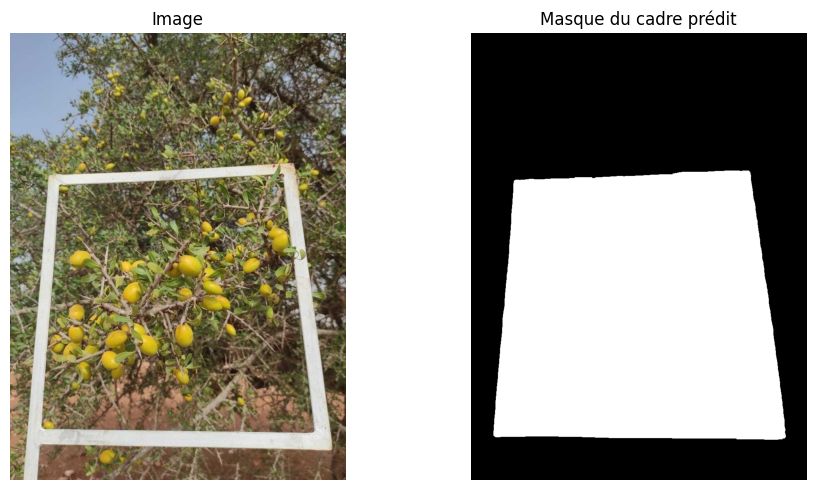

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
img_array = io.imread(img_p)
axs[0].imshow(img_array)
axs[0].axis("off")
axs[0].set_title("Image")
axs[1].imshow(msk_cadre_predit_post_processed, cmap="gray")
axs[1].axis("off")
axs[1].set_title("Masque du cadre prédit")
fig.tight_layout()

In [42]:
for name in list_imgs_val:
  file_img = base_path + "valid/images/" + name + ".jpg"
  file_label = base_path + "valid/labels/" + name + ".txt"
  pols = get_polygons(path_to_label_file=file_label, image_path=file_img)
  fruits_msk = show_pols(pols, Image.open(file_img))
  msk = pols_to_mask(polygons=pols, img_path=file_img, edge_width=3, fill_color="white", outline="black")
  msk_fruit_axis = show_axes_on_fruits(fruits_msk, mask_image=np.array(msk), width=2)
  # msk_fruit_axis.save(save_fold + name + "_vis_fruits_dims" + ".jpg")


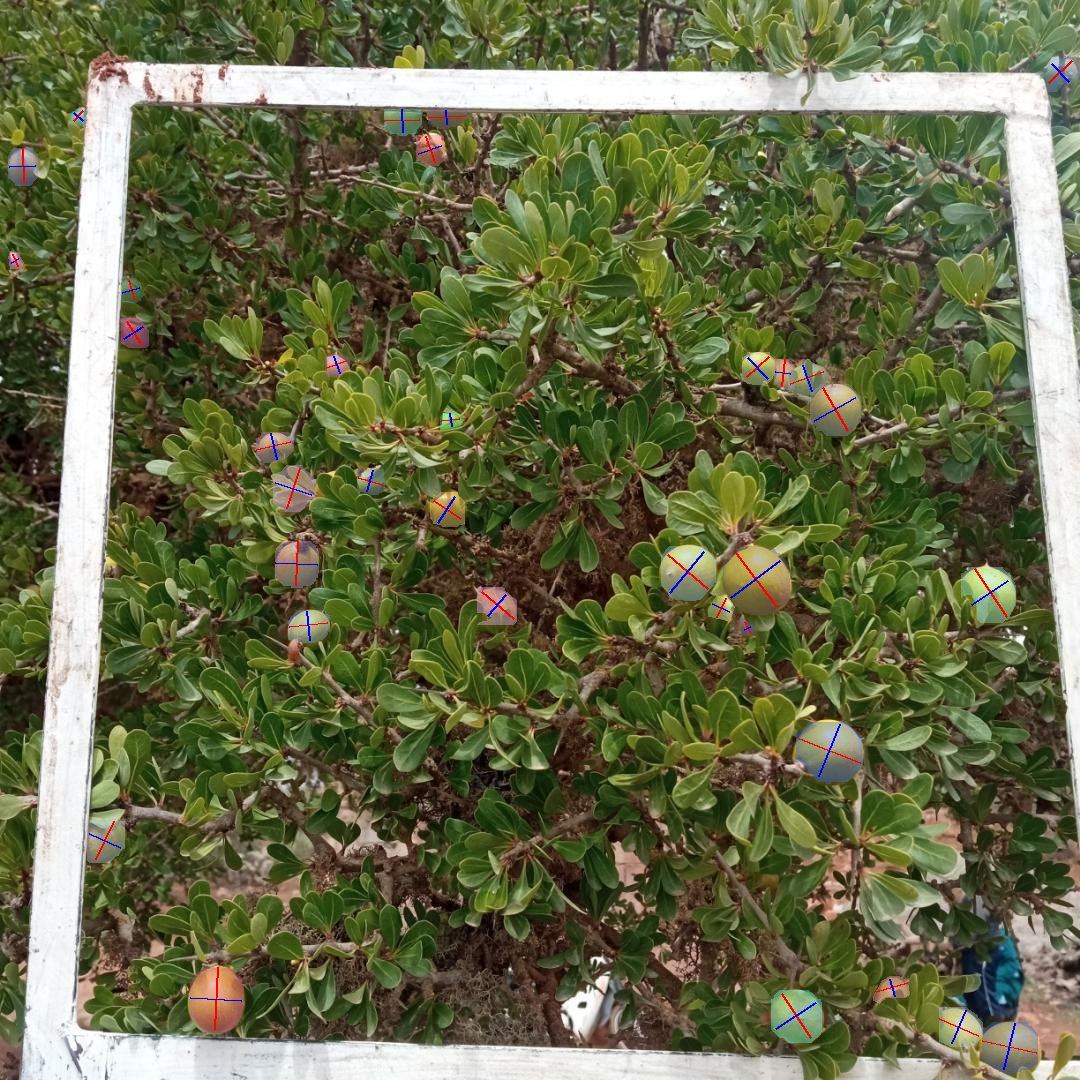

In [43]:
msk_fruit_axis

In [ ]:
pols = get_polygons(path_to_label_file=file_label, image_path=file_img)

In [ ]:
fruits_msk = show_pols(pols, Image.open(file_img))

In [ ]:
msk = pols_to_mask(polygons=pols, img_path=file_img, edge_width=3, fill_color="white", outline="black")
msk_fruit_axis = show_axes_on_fruits(fruits_msk, mask_image=np.array(msk))

In [ ]:
msk_fruit_axis.save(save_fold + list_imgs_val[0] + ".jpg")

In [14]:
model_path = "/content/drive/MyDrive/ModelsTraining/ModelsYOLOFinal/ComparaisonModels/yolov8s-seg/weights/best.pt"

## Fonctions de prédiction

In [12]:
df_images = pd.read_csv("/content/drive/MyDrive/ModelsTraining/ModelsYOLOFinal/ComparaisonModels/SlicingEvaluation/RatiosTailleFruits/DonneesIMAGES.csv")

In [13]:
df_images.head()

Commune  Num_placette  NumArbrEchan OrientationImage  \
0     BIG            10             1    CadreFruitEst   
1     BIG            10             2    CadreFruitEst   
2     BIG            10             3    CadreFruitEst   
3     BIG            10             1   CadreFruitNord   
4     BIG            10             2   CadreFruitNord   

                                               Image DateAcquisition   arbreID  
0  BIG_10_CadreFruitEst_ArbreEch_1_V1_2022-03-26.jpg      2022-03-26  1-BIG_10  
1  BIG_10_CadreFruitEst_ArbreEch_2_V1_2022-03-26.jpg      2022-03-26  2-BIG_10  
2  BIG_10_CadreFruitEst_ArbreEch_3_V1_2022-03-26.jpg      2022-03-26  3-BIG_10  
3  BIG_10_CadreFruitNord_ArbreEch_1_V1_2022-03-26...      2022-03-26  1-BIG_10  
4  BIG_10_CadreFruitNord_ArbreEch_2_V1_2022-03-26...      2022-03-26  2-BIG_10

In [8]:
def get_trees_ids(dataframe):
  """
    Récupérer la liste des identifiant des arbres
  """
  return dataframe.arbreID.unique().tolist()

def get_tree_images(tree_id, dataframe, tree_id_field="arbreID", image_field="Image"):
  """
    Récupère les 4 images correspondant à l'arbre donné
    tree_id : identifiant de l'arbre
    dataframe : dataframe pandas contenant les données

    return:
      list de 4 images
  """
  donnees = dataframe[dataframe[tree_id_field] == tree_id]
  images = donnees[image_field].to_list()
  return images

def get_predicted_mask(image_path, imgs=960):
  """
    Prédire le cadre se trouvant dans l'image
  """
  model_cadre_path = "/content/drive/MyDrive/ModelsTraining/SegmentFrameFinale/NoAttention/weights/last.pt"
  model_cadre = SegmentationModel(model_cadre_path)
  msk_cadre_predit = model_cadre.predict(image=image_path, prediction_size=imgs, device=get_device())
  msk_cadre_processed = post_process_mask(msk_cadre_predit) * 255
  return msk_cadre_processed

def draw_n_fruits_on_image(image, text, position=(20, 20), rectangle_fill_color=(255, 255, 255, 180), text_color="black", text_size=25):
    font = ImageFont.truetype("/content/drive/MyDrive/ModelsTraining/arial/ARIAL.TTF", text_size)
    # ImageFont.truetype("arial.ttf", text_size)
    image = image
    if isinstance(image, str):
      image = Image.open(image)
    draw = ImageDraw.Draw(image, "RGBA")

    left, top, right, bottom = draw.textbbox(position, text, font=font)
    draw.rectangle((left-5, top-5, right+5, bottom+5), fill=rectangle_fill_color)
    draw.text(position, text, font=font, fill=text_color)
    return image

In [9]:
model_path = "/content/drive/MyDrive/ModelsTraining/ModelsYOLOFinal/ComparaisonModels/yolov8s-seg/weights/best.pt"
model = YOLO(model_path)

In [10]:
IMAGES_PATH = "/content/drive/MyDrive/ModelsTraining/ImagesMFE/"
SAVE_PATH = "/content/drive/MyDrive/ModelsTraining/PredImages"

In [28]:
liste_arbres_ids = get_trees_ids(df_images)

In [29]:
dict_donnes_images = {
    "tree_id": [],
    "image": [],
    "categorie_fruit": [],
    "nombre_fruits": [],
    "poids_du_fruit": [],
    "poids_total": []
}

dict_donnes_arbres = {
    "tree_id": [],
    "categorie_fruit": [],
    "nombre_moyen_fruits": [],
    "poids_du_fruit": [],
    "poids_moyen_cadre": []
}

In [ ]:
for tree_id in tqdm.tqdm(liste_arbres_ids, total=len(liste_arbres_ids)):
  liste_images = get_tree_images(tree_id, df_images)
  list_imgs_paths = [os.path.join(IMAGES_PATH, img_name) for img_name in liste_images]

  nombres_fruits = []
  noms_images = []
  liste_ratios = []
  images_annotees = []
  masques_cadre = []
  for img_p in list_imgs_paths:
    nom_image = img_p.split("/")[-1]
    noms_images.append(nom_image)

    # Pour chaque image : prédire le cadre et les fruits
    mask_predit = get_predicted_mask(image_path=img_p, imgs=960)
    masques_cadre.append(mask_predit)

    nbr_fruits, ratios, masques = get_yolo_pred(model, img_p, img_size=None, conf=0.5, iou=0.7, masque_du_cadre=mask_predit)
    nombres_fruits.append(nbr_fruits)

    # Ajouter le ratio à la liste des ratios
    liste_ratios += ratios

    # Annoté l'image avec les polygones prédits
    image_annotee = show_pols(masques, Image.open(img_p), transparence=130)
    images_annotees.append(image_annotee)

  # Déterminer la catégorie du fruit et le poids unitaire
  categorie, poids_fruit = check_and_compute_weight(liste_ratios)

  # Annotation finale et sauvegarde des images
  for img_name, n_fruits, img, masque_du_cadre in zip(noms_images, nombres_fruits, images_annotees, masques_cadre):
    final_img_annotated = draw_n_fruits_on_image(
        image=img,
        text=f"Nombre de fruits: {n_fruits} | Catégorie: {categorie} | Poids unitaire : {poids_fruit} g | Poids total : {'{:.2f}'.format(n_fruits * poids_fruit)} g"
        )
    final_img_annotated.save(os.path.join(SAVE_PATH, "Images", img_name))
    Image.fromarray(masque_du_cadre).save(os.path.join(SAVE_PATH, "Masques", img_name.replace(".jpg", ".png")))

    dict_donnes_images["tree_id"].append(tree_id)
    dict_donnes_images["image"].append(img_name)
    dict_donnes_images["categorie_fruit"].append(categorie)
    dict_donnes_images["nombre_fruits"].append(n_fruits)
    dict_donnes_images["poids_du_fruit"].append(poids_fruit)
    dict_donnes_images["poids_total"].append(n_fruits * poids_fruit)

  dict_donnes_arbres["tree_id"].append(tree_id)
  dict_donnes_arbres["categorie_fruit"].append(categorie)
  dict_donnes_arbres["nombre_moyen_fruits"].append(int(sum(nombres_fruits) / len(nombres_fruits)))
  dict_donnes_arbres["poids_du_fruit"].append(poids_fruit)
  dict_donnes_arbres["poids_moyen_cadre"].append(int(sum(nombres_fruits) / len(nombres_fruits)) * poids_fruit)


  pd.DataFrame(dict_donnes_images).to_csv(os.path.join(SAVE_PATH, "prediction_images_conf_0_5.csv"), index=False)
  pd.DataFrame(dict_donnes_arbres).to_csv(os.path.join(SAVE_PATH, "prediction_arbres_conf_0_5.csv"), index=False)

100%|██████████| 939/939 [1:20:18<00:00,  5.13s/it]


## Prédiction du nombre de fruits à l'intérieur du cadre et visualisation

In [56]:
imgs = [
    "BIG_35_CadreFruitNord_ArbreEch_1_V1_2022-03-28.jpg",
    "BOU_4_CadreFruitNord_ArbreEch_2_V1_2022-04-01.jpg",
    "SAA_24_CadreFruitEst_ArbreEch_1_V1_2022-03-31.jpg",
    "SAA_32_CadreFruitEst_ArbreEch_2_V1_2022-03-31.jpg",
    "SBO_15_CadreFruitOuest_ArbreEch_2_V1_2022-03-30.jpg",
    "IMQ_9_CadreFruitSud_ArbreEch_1_V1_2022-03-24.jpg",
    "SBO_27_CadreFruitSud_ArbreEch_1_V1_2022-03-30.jpg"

]

base_path = "/content/drive/MyDrive/ModelsTraining/ModelsYOLOFinal/atf-1/valid/"
save_fold = "/content/drive/MyDrive/ModelsTraining/ModelsYOLOFinal/ImagespredRefrapport/"
model_path = "/content/drive/MyDrive/ModelsTraining/ModelsYOLOFinal/ComparaisonModels/yolov8s-seg/weights/best.pt"
model = YOLO(model_path)

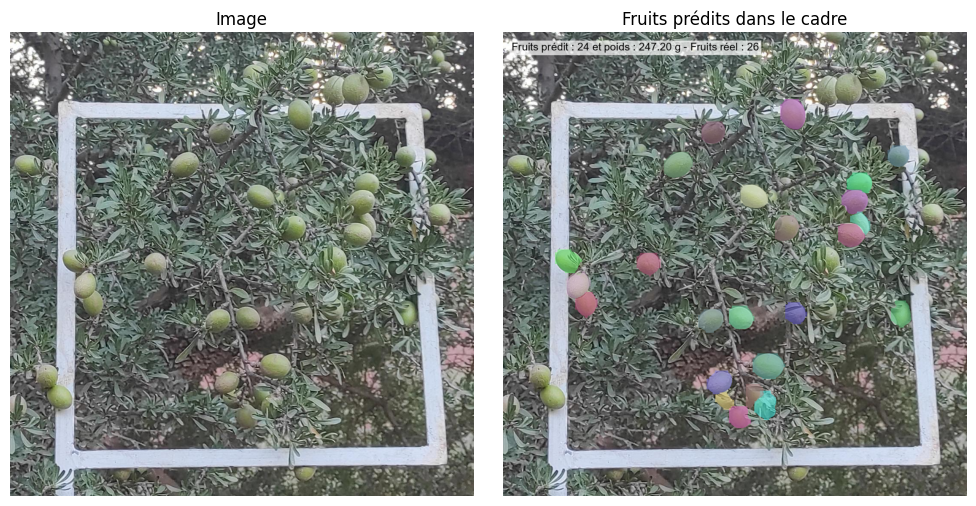

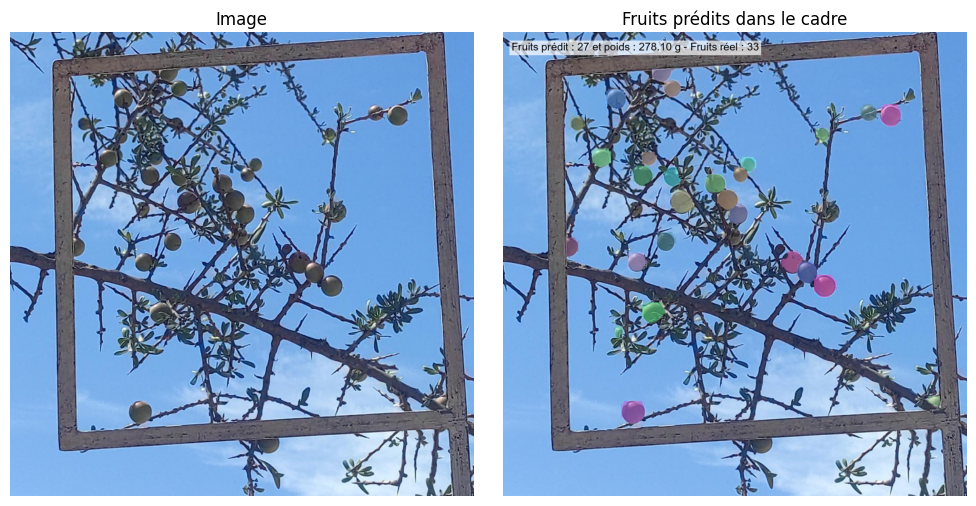

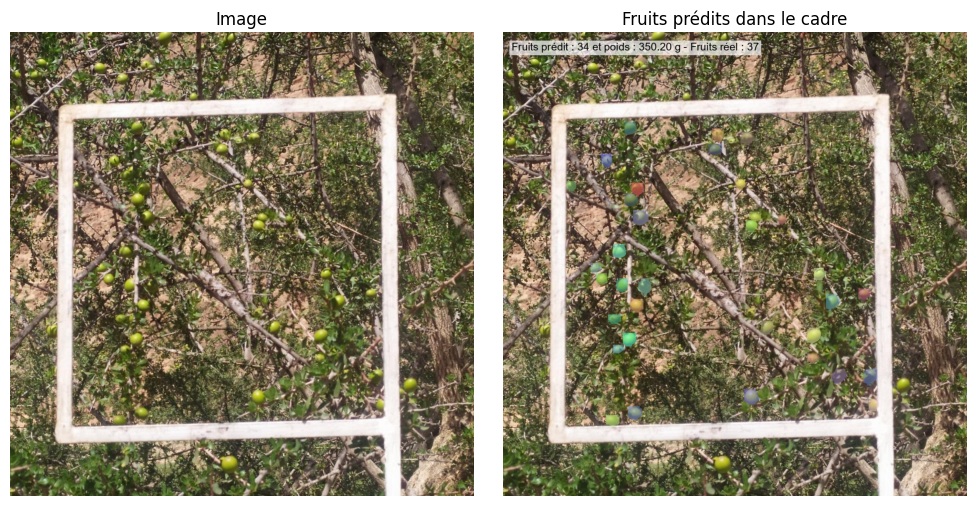

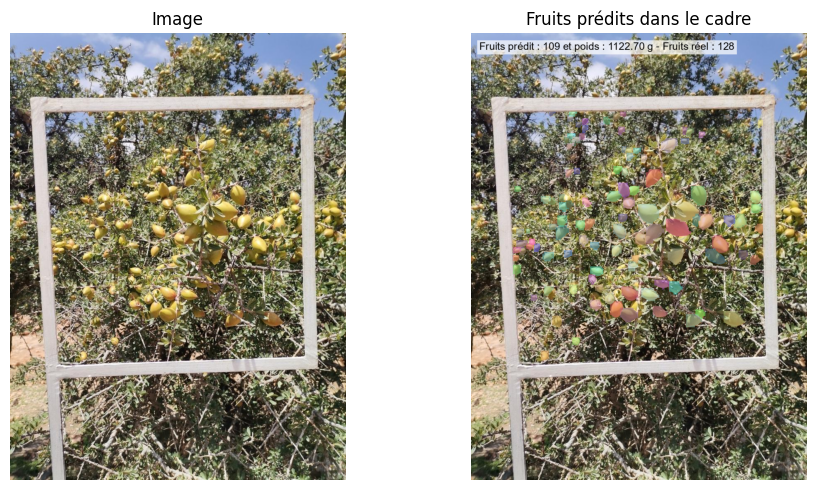

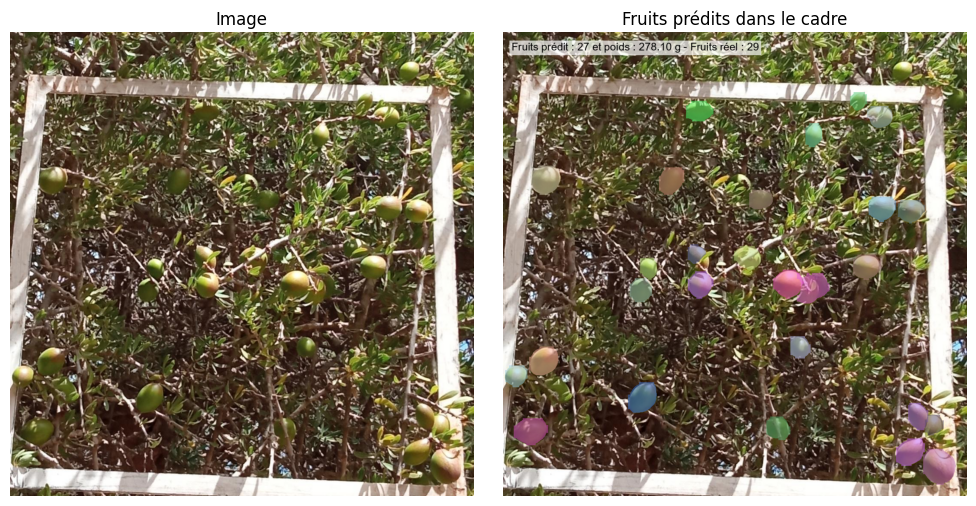

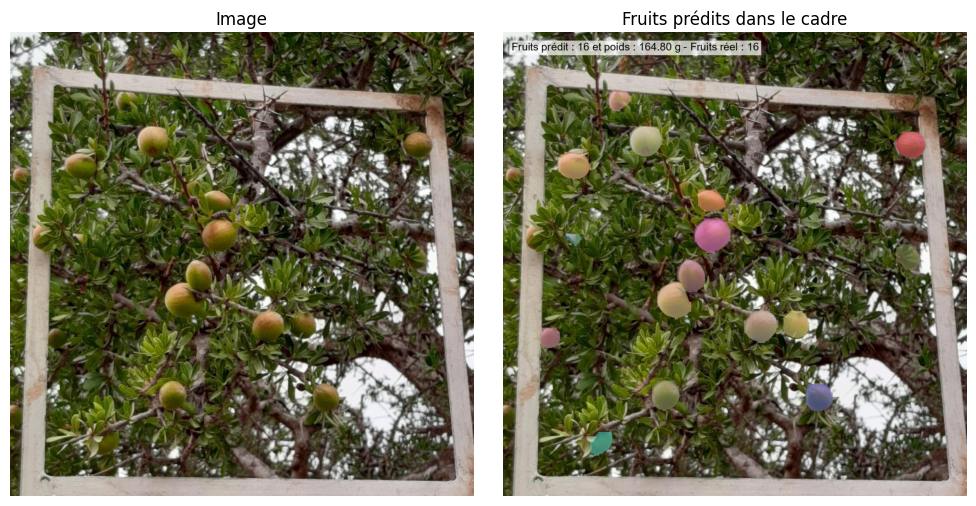

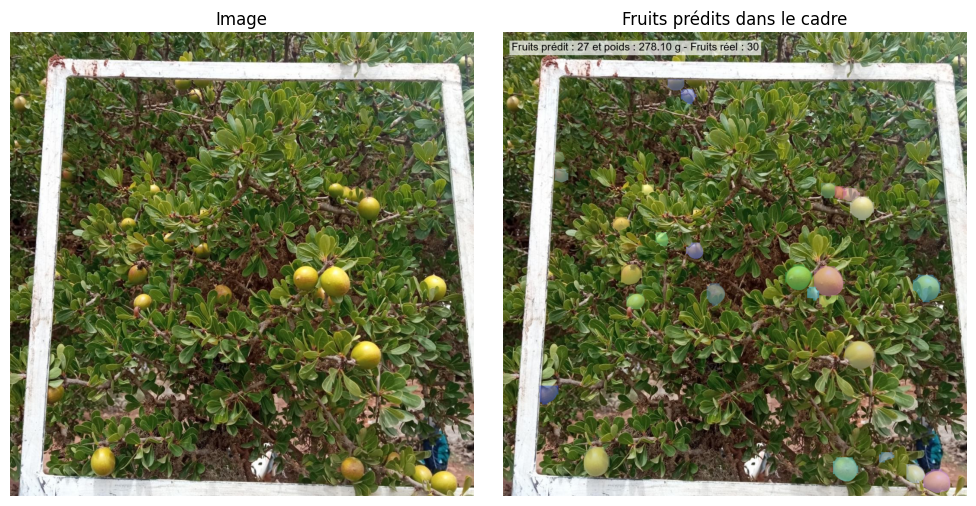

In [57]:
for img in imgs:
  img_p = base_path + "images/" + img
  lbl_p = base_path + "labels/" + img.replace(".jpg", ".txt")
  masque_reel_p = base_path + "cadrereels/" + img.replace(".jpg", ".png")
  img_name = img.split(".")[0]

  # Pour chaque image : prédire le cadre et les fruits
  mask_predit = get_predicted_mask(image_path=img_p, imgs=960)
  nbr_fruits_msk, categorie, poids_fruits, masks_fruits_msk = get_yolo_pred(model, img_p, img_size=None, conf=0.5, iou=0.7, masque_du_cadre=mask_predit)
  # nbr_fruits_no_msk, categorie1, poids_no_msk, masks_fruits_no_msk = get_yolo_pred(model, img_p, img_size=None, conf=0.5, iou=0.7, masque_du_cadre=None)

  # Les données réelles
  pols_reels = get_polygons(path_to_label_file=lbl_p, image_path=img_p)
  pols_reels_centers = polygons_to_points(pols_reels)
  n_reel_no_mask = len(pols_reels)
  masks_reels_in_cadre = get_correct_masks(masque_reel_p, boites=pols_reels_centers, masques=pols_reels)
  n_reel_in_mask = len(masks_reels_in_cadre)  # get_True_number_fruits(img_p, lbl_p, mask_cadre_path=masque_reel_p)


  # Annoté l'image avec les polygones prédits
  image_pred_avec_mask_annot = show_pols(masks_fruits_msk, Image.open(img_p), transparence=130)
  # image_pred_sans_mask_annot = show_pols(masks_fruits_no_msk, Image.open(img_p), transparence=130)
  # image_reel_avec_mask_annot = show_pols(masks_reels_in_cadre, Image.open(img_p), transparence=130)
  # image_reel_sans_mask_annot = show_pols(pols_reels, Image.open(img_p), transparence=130)

  # Mettre le nombre de fruits sur les images
  image_pred_avec_mask_annot = draw_n_fruits_on_image(image=image_pred_avec_mask_annot,text=f"Fruits prédit : {nbr_fruits_msk} et poids : {'{:.2f}'.format(poids_fruits)} g - Fruits réel : {n_reel_in_mask}")
  # image_pred_sans_mask_annot = draw_n_fruits_on_image(image=image_pred_sans_mask_annot,text=f"Fruits prédit : {nbr_fruits_no_msk} - Fruits réel : {n_reel_no_mask}")
  # image_reel_avec_mask_annot = draw_n_fruits_on_image(image=image_reel_avec_mask_annot,text=f"Fruits : {n_reel_in_mask}")
  # image_reel_sans_mask_annot = draw_n_fruits_on_image(image=image_reel_sans_mask_annot,text=f"Fruits : {n_reel_no_mask}")

  # Sauvegarder les images
  # image_pred_avec_mask_annot.save(os.path.join(save_fold, img_name + "PRED_AVEC_MASK" + ".jpg"))
  # image_pred_sans_mask_annot.save(os.path.join(save_fold, img_name + "PRED_SANS_MASK" + ".jpg"))
  # image_reel_avec_mask_annot.save(os.path.join(save_fold, img_name + "REEL_AVEC_MASK" + ".jpg"))
  # image_reel_sans_mask_annot.save(os.path.join(save_fold, img_name + "REEL_SANS_MASK" + ".jpg"))
  # Image.fromarray(mask_predit).save(os.path.join(save_fold, img_name + ".png"))
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  img_array = io.imread(img_p)
  axs[0].imshow(img_array)
  axs[0].axis("off")
  axs[0].set_title("Image")
  axs[1].imshow(np.asarray(image_pred_avec_mask_annot))
  axs[1].axis("off")
  axs[1].set_title("Fruits prédits dans le cadre")
  fig.tight_layout()